In [1]:
import geopandas as gpd
import networkx as nx
import pandas as pd
import tempun
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from celluloid import Camera
import random
import geopandas as gpd
from shapely.geometry import LineString, Point, MultiPoint

import google_conf

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from IPython.display import HTML
#result = pyreadr.read_r('/path/to/file.Rds')


In [2]:
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"


def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_83838/3721426264.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [3]:
provinces = gpd.read_file("../data/roman_province_boundaries.json") # province file from "https://edh.ub.uni-heidelberg.de/data/download/roman_province_boundaries.json"
# however, there are invalid geometries... the following solution is based on advice from ChatGPT...
invalid_geometries = provinces[~provinces.geometry.is_valid]
# Make invalid geometries valid by buffering with a distance of 0
provinces.loc[~provinces.geometry.is_valid, 'geometry'] = invalid_geometries.buffer(0)
provinces = provinces.to_crs(3035)
# provinces.to_file("../data/provinces_valid.geojson")
#provinces = gpd.read_file("../data/provinces_valid.geojson")
provinces = provinces.to_crs("EPSG:4326")#
len(provinces)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/pygeos/constructive.py:175: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


61

In [4]:
pleiades_regions_merged = provinces.unary_union

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/pygeos/set_operations.py:388: RuntimeWarning: invalid value encountered in unary_union
  result = lib.unary_union(collections, **kwargs)


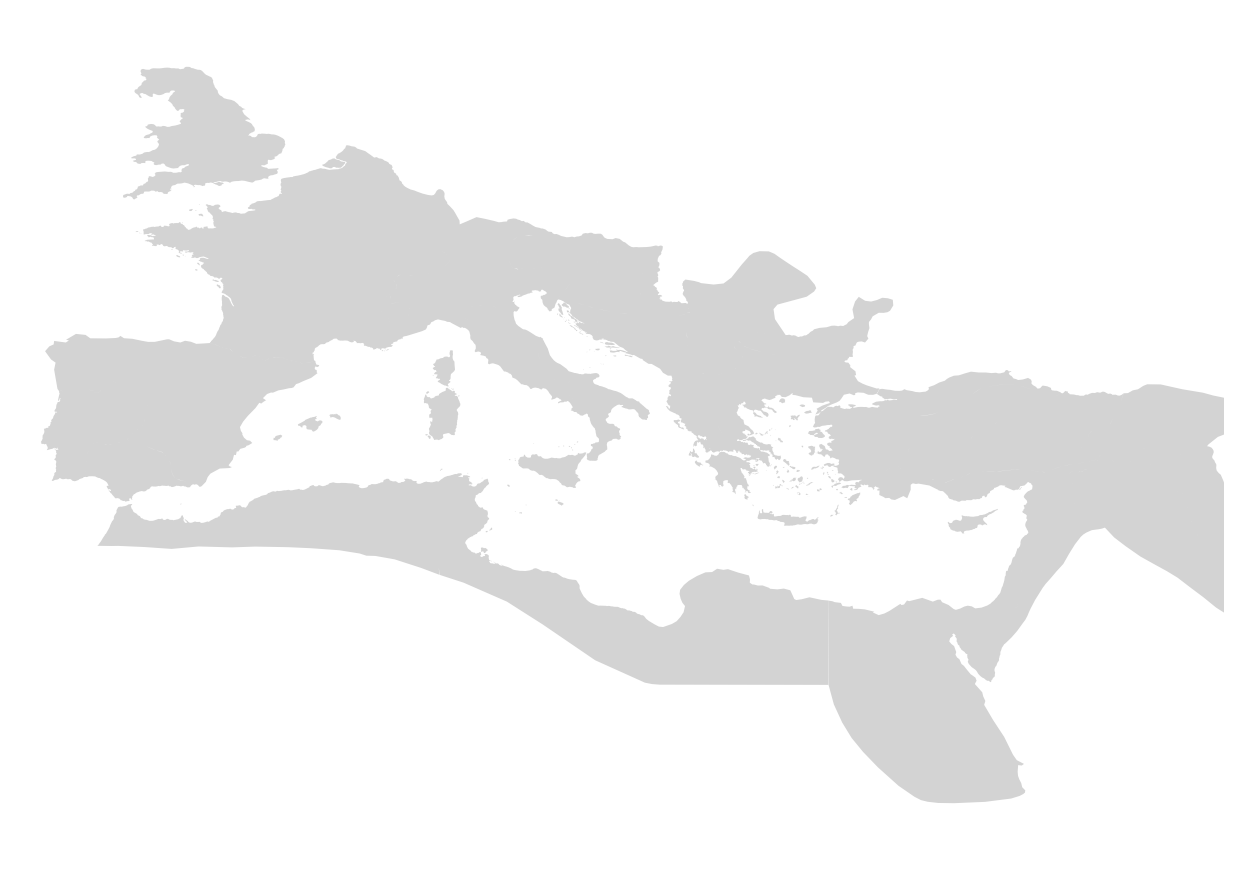

In [5]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
#GIST.plot()
ax.set_xlim(-10, 45)
ax.set_axis_off()

In [6]:
origo_sheet = google_conf.setup("https://docs.google.com/spreadsheets/d/17ibTaRJHHevY2wVsx9aK-NEd54fGho69l5dGJNE3XBA/edit?usp=sharing", service_account_path="../../ServiceAccountsKey.json")
origo_df = google_conf.get_as_dataframe(origo_sheet.worksheet("2023WORKSHEET"))

In [7]:
#origo_df = pd.read_json("../data/origo_df.json")

In [8]:
origo_geo = origo_df[origo_df["pleiades_Latitude"].notnull() & origo_df["pleiades_Longitude"].notnull()] # we had 1723 last time
len(origo_geo)

2464

In [15]:
origo_geo["origo_point"] = origo_geo.apply(lambda row: Point([row["pleiades_Longitude"], row["pleiades_Latitude"]]), axis=1)
origo_geo = gpd.GeoDataFrame(origo_geo, geometry=origo_geo["origo_point"])

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_83838/826567250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origo_geo["origo_point"] = origo_geo.apply(lambda row: Point([row["pleiades_Longitude"], row["pleiades_Latitude"]]), axis=1)


<Axes: >

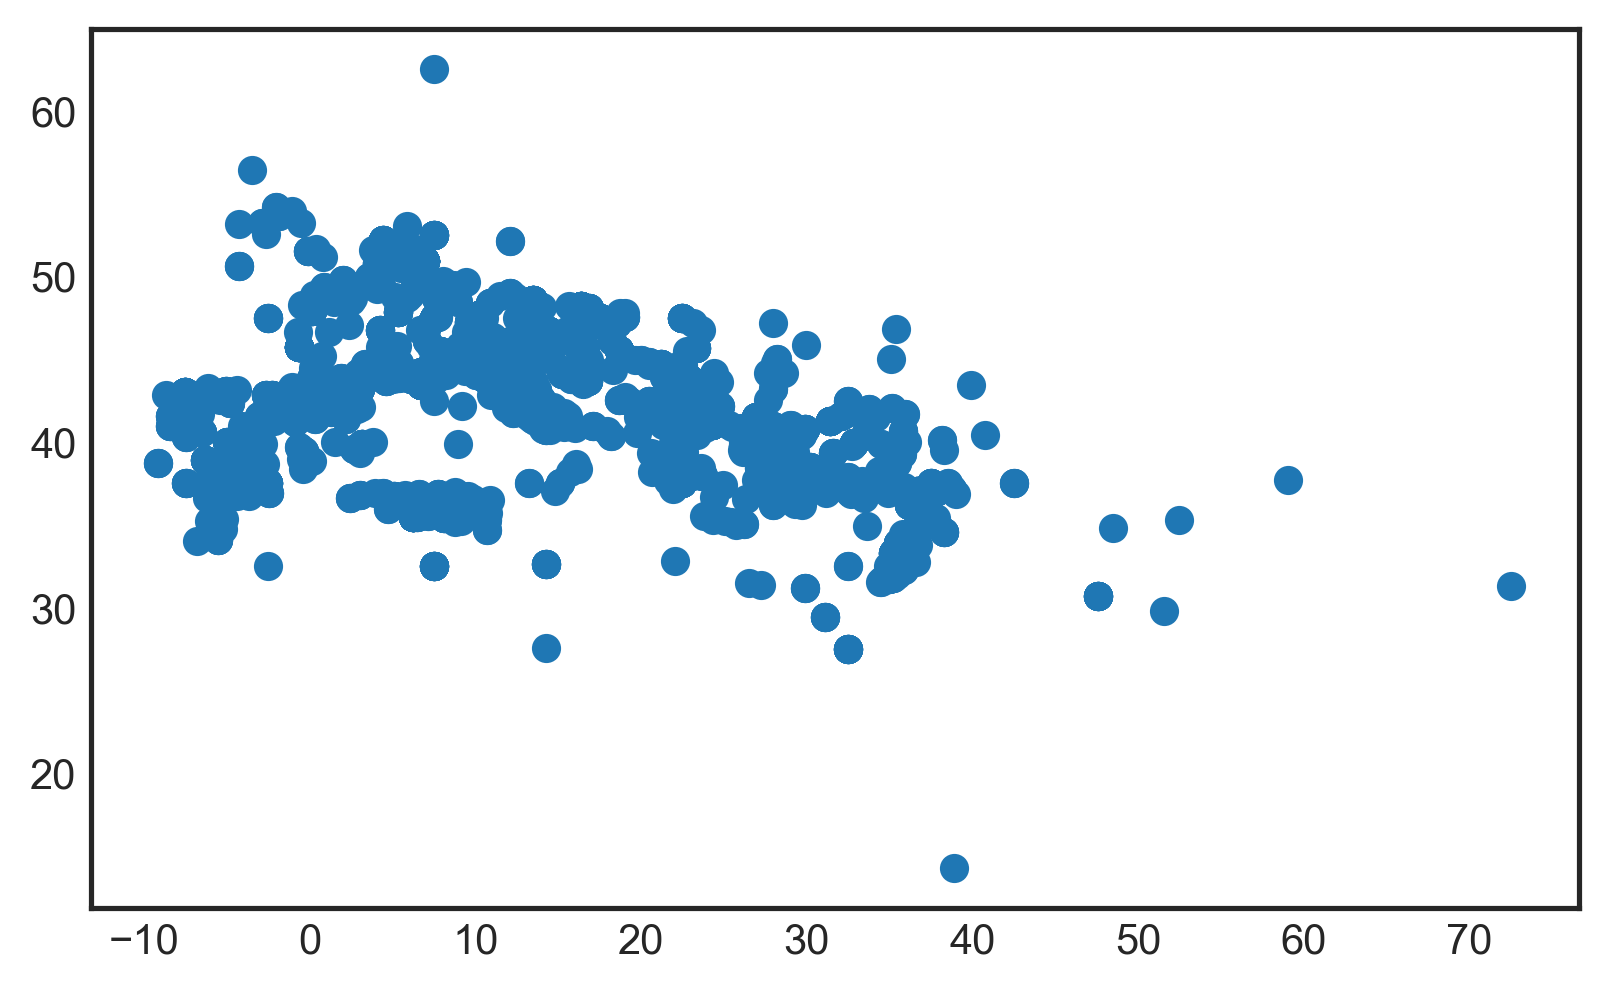

In [16]:
origo_geo.plot()

In [9]:
# we will need some other metadata from the inscriptions
# use your own dataset for EDH metadata
try:
    LIST = gpd.read_parquet("../../LI_ETL/data/large_data/LIST_v0-6.parquet")
except:
    LIST = gpd.read_parquet("https://zenodo.org/record/7993915/files/LIST_v0-5.parquet?download=1")

In [10]:
#LIST = LIST.rename(columns={"not_before" : "not_after", "not_after" : "not_before"})
LIST.head(5)

LIST-ID        EDCS-ID    EDH-ID  \
445463   445464  EDCS-24900077  HD056163   
445464   445465  EDCS-03700724  HD052964   
445465   445466  EDCS-13800065  HD017714   
445466   445467  EDCS-03300852  HD051000   
445467   445468  EDCS-28500283  HD021396   

                                trismegistos_uri pleiades_id  \
445463  https://www.trismegistos.org/text/177366      570485   
445464  https://www.trismegistos.org/text/121715      531064   
445465  https://www.trismegistos.org/text/177100      570049   
445466  https://www.trismegistos.org/text/177273      240855   
445467  https://www.trismegistos.org/text/177131               

                                            transcription  \
445463  Q(uinto) Caecilio C(ai) f(ilio) Metelo / imper...   
445464  Fortissimo et piis/simo Caesari d(omino) n(ost...   
445465  Italicei / quei Aegei negotiantur / P(ublium) ...   
445466  [Imp(eratori) Caes(ari) M(arco)] / An[nio] Flo...   
445467  T[i(berius)] Claudius Caesar Aug(ustus) / G[er...   

                                              inscription  \
445463  Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...   
445464  Fortissimo et Piis/simo Caesari d(omino) n(ost...   
445465  Italicei / quei Aegei negotiantur / P(ublium) ...   
445466  Imp(eratori) / Floriano / P(io) F(elici) Aug(u...   
445467  T[(iberius)] Claudius Caesar Aug(ustus) / G[er...   

                                  clean_text_conservative  \
445463  Q Caecilio C f Metelo imperatori Italici quei ...   
445464  Fortissimo et piissimo Caesari d n Gal Val P F...   
445465  Italicei quei Aegei negotiantur P Rutilium P f...   
445466  An Floriano P F Aug p p m p III Imp Caes M Aur...   
445467  T Claudius Caesar Aug Ganicus pontif max trib ...   

                         clean_text_interpretive_sentence  \
445463  Quinto Caecilio Cai filio Metelo imperatori It...   
445464  Fortissimo et piissimo Caesari domino nostro G...   
445465  Italicei quei Aegei negotiantur Publium Rutili...   
445466  Imperatori Caesari Marco Annio Floriano Pio Fe...   
445467  Tiberius Claudius Caesar Augustus Germanicus p...   

                             clean_text_interpretive_word  ...  Longitude  \
445463  Quinto Caecilio Cai filio Metelo imperatori It...  ...  22.841200   
445464  Fortissimo et piissimo Caesari domino nostro G...  ...  20.766800   
445465  Italicei quei Aegei negotiantur Publium Rutili...  ...  22.084500   
445466  Imperatori Caesari Marco Annio Floriano Pio Fe...  ...  22.417100   
445467  Tiberius Claudius Caesar Augustus Germanicus p...  ...  22.420877   

         Latitude geotemporal?               geometry withinRE? urban_context  \
445463  37.649800         True  POINT (22.841 37.650)      True         rural   
445464  39.451200         True  POINT (20.767 39.451)      True         rural   
445465  38.248700         True  POINT (22.084 38.249)      True         small   
445466  37.431900         True  POINT (22.417 37.432)      True         large   
445467  37.454501         True  POINT (22.421 37.455)      True         large   

       urban_context_city urban_context_pop_est  type_of_inscription_auto  \
445463               None                   NaN     honorific inscription   
445464               None                   NaN     honorific inscription   
445465             Aegium                1000.0        votive inscription   
445466              Tegea               46362.0         mile-/leaguestone   
445467              Tegea               46362.0  public legal inscription   

       type_of_inscription_auto_prob  
445463                           1.0  
445464                           1.0  
445465                           1.0  
445466                           1.0  
445467                           1.0  

[5 rows x 66 columns]

In [11]:
len(LIST[LIST["EDH-ID"].isin(origo_geo["hd_nr"])])

1979

In [13]:
# list filtered to EDH only

LIST_edh= LIST[LIST["EDH-ID"].notnull()]
LIST_edh = LIST_edh[(LIST_edh["not_before"].notnull() | LIST_edh["not_after"].notnull())]

# assign random dates using tempun
LIST_edh["random_dates"] = LIST_edh.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=10, antepost=True),axis=1)
LIST_edh["random_date"] = LIST_edh["random_dates"].apply(lambda x: x[0])

In [14]:
LIST_edh

LIST-ID        EDCS-ID    EDH-ID  \
445463   445464  EDCS-24900077  HD056163   
445464   445465  EDCS-03700724  HD052964   
445465   445466  EDCS-13800065  HD017714   
445466   445467  EDCS-03300852  HD051000   
445467   445468  EDCS-28500283  HD021396   
...         ...            ...       ...   
525865   525866           None  HD082771   
525866   525867           None  HD082808   
525867   525868           None  HD082809   
525868   525869           None  HD082812   
525869   525870           None  HD082816   

                                trismegistos_uri pleiades_id  \
445463  https://www.trismegistos.org/text/177366      570485   
445464  https://www.trismegistos.org/text/121715      531064   
445465  https://www.trismegistos.org/text/177100      570049   
445466  https://www.trismegistos.org/text/177273      240855   
445467  https://www.trismegistos.org/text/177131               
...                                          ...         ...   
525865                                      None      207361   
525866                                      None      207304   
525867  https://www.trismegistos.org/text/705780      187583   
525868                                      None      197273   
525869                                      None      118802   

                                            transcription  \
445463  Q(uinto) Caecilio C(ai) f(ilio) Metelo / imper...   
445464  Fortissimo et piis/simo Caesari d(omino) n(ost...   
445465  Italicei / quei Aegei negotiantur / P(ublium) ...   
445466  [Imp(eratori) Caes(ari) M(arco)] / An[nio] Flo...   
445467  T[i(berius)] Claudius Caesar Aug(ustus) / G[er...   
...                                                   ...   
525865  ------] /[--- vixit an]nis / [--- Ger?]man/[us...   
525866  Silvan/o Dom(estico) / Aureli(us) / Annia/nus ...   
525867  [Dis] / Maiorib(us) / [T]urboni/[u]s [---] / [...   
525868                                       MISALIV[---]   
525869                                     Iunio / [-]VMT   

                                              inscription  \
445463  Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...   
445464  Fortissimo et Piis/simo Caesari d(omino) n(ost...   
445465  Italicei / quei Aegei negotiantur / P(ublium) ...   
445466  Imp(eratori) / Floriano / P(io) F(elici) Aug(u...   
445467  T[(iberius)] Claudius Caesar Aug(ustus) / G[er...   
...                                                   ...   
525865                                               None   
525866                                               None   
525867                                               None   
525868                                               None   
525869                                               None   

                                  clean_text_conservative  \
445463  Q Caecilio C f Metelo imperatori Italici quei ...   
445464  Fortissimo et piissimo Caesari d n Gal Val P F...   
445465  Italicei quei Aegei negotiantur P Rutilium P f...   
445466  An Floriano P F Aug p p m p III Imp Caes M Aur...   
445467  T Claudius Caesar Aug Ganicus pontif max trib ...   
...                                                   ...   
525865                                   nis man ex arioV   
525866                     Silvano Dom Aureli Annianus pr   
525867                                Maiorib urbonis Tur   
525868                                            MISALIV   
525869                                          Iunio VMT   

                         clean_text_interpretive_sentence  \
445463  Quinto Caecilio Cai filio Metelo imperatori It...   
445464  Fortissimo et piissimo Caesari domino nostro G...   
445465  Italicei quei Aegei negotiantur Publium Rutili...   
445466  Imperatori Caesari Marco Annio Floriano Pio Fe...   
445467  Tiberius Claudius Caesar Augustus Germanicus p...   
...                                                   ...   
525865  vixit annis Germanus veteranus ex cohortis sag...   
525866             Silv

In [17]:
# map EDH metadata on origo_geo dataset

edh_geo_dict = dict(zip(LIST_edh["EDH-ID"], LIST_edh["geometry"]))
edh_date_dict = dict(zip(LIST_edh["EDH-ID"], LIST_edh["random_date"]))
edh_notbefore_dict = dict(zip(LIST_edh["EDH-ID"], LIST_edh["not_before"]))
edh_notafter_dict = dict(zip(LIST_edh["EDH-ID"], LIST_edh["not_after"]))

def get_val_from_dict(x, data_dict):
    try:
        return data_dict[x]
    except:
        return None
origo_geo["edh_point"] = origo_geo["hd_nr"].apply(lambda x: get_val_from_dict(x, edh_geo_dict))
origo_geo["random_date"] = origo_geo["hd_nr"].apply(lambda x: get_val_from_dict(x, edh_date_dict))

origo_geo["not_before"] = origo_geo["hd_nr"].apply(lambda x: get_val_from_dict(x, edh_notbefore_dict))
origo_geo["not_after"] = origo_geo["hd_nr"].apply(lambda x: get_val_from_dict(x, edh_notafter_dict))

In [19]:
origo_geo["edh_point"].tolist()[:5]

In [20]:
origo_geo = origo_geo[(origo_geo["random_date"].notnull()) & (origo_geo["origo_point"].notnull()) & (origo_geo["edh_point"].notnull())]
len(origo_geo)

2287

In [21]:
len(set(origo_geo["hd_nr"]))

1961

# Simple lines

In [22]:
origo_geo["origo_line"] = origo_geo.apply(lambda row: LineString([row["origo_point"], row["edh_point"]]), axis=1)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/shapely/geometry/linestring.py:47: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  ret = geos_linestring_from_py(coordinates)


IndexError: tuple index out of range

In [26]:
origo_geo

Unnamed: 0            id     hd_nr                          origo  \
0          87598    HD075902/1  HD075902    cives(!) (= civis) Nervius+   
1          92334    HD081444/1  HD081444            natione(?)Pannonius   
2          62290    HD056833/3  HD056833        cives(= civis) Convena*   
3          19842    HD018231/1  HD018231  cives(= civis) Veliocassinius   
4          15178    HD010286/1  HD010286    natione+* [---] Aelia [---]   
...          ...           ...       ...                            ...   
2564       32589  HD032316/128  HD032316                        Zerna*?   
2566       40288    HD037345/1  HD037345                 natione Zoela!   
2589       61629    HD056506/2  HD056506                        Ἐφέσιος   
2607       25320    HD025474/5  HD025474                       Μιλήσιος   
2637       13801    HD008584/6  HD008584                  natione verna   

              origo_clean  pleiades_id pleiades_title_list  pleiades_Latitude  \
0         () (= ) Nervius     109199.0                 NaN          50.777494   
1             ()Pannonius     992076.0                 NaN          47.500000   
2            (= ) Convena     246357.0                 NaN          42.966682   
3     (= ) Veliocassinius     109412.0                 NaN          49.364001   
4       [---] Aelia [---]     197389.0                 NaN          45.560018   
...                   ...          ...                 ...                ...   
2564                Zerna     207078.0                 NaN          44.731710   
2566                Zoela     236724.0                 NaN          41.717349   
2589              Ἐφέσιος     599612.0                 NaN          37.940762   
2607             Μιλήσιος     599799.0                 NaN          37.522905   
2637                  NaN     167964.0                 NaN          45.776152   

      pleiades_Longitude       pleiades_title  ... Unnamed: 24 Unnamed: 25  \
0               4.084768               Nervii  ...         NaN         NaN   
1              12.500000            Pannoniae  ...         NaN         NaN   
2               0.269919             Convenae  ...         NaN         NaN   
3               0.831097          Veliocasses  ...         NaN         NaN   
4              18.675749                Mursa  ...         NaN         NaN   
...                  ...                  ...  ...         ...         ...   
2564           22.401909               Dierna  ...         NaN         NaN   
2566           -6.628006               Zoelae  ...         NaN         NaN   
2589           27.340307  Ephesus/Arsinoe(ia)  ...         NaN         NaN   
2607           27.278317              Miletus  ...         NaN         NaN   
2637            5.281057               Vernas  ...         NaN         NaN   

     Unnamed: 26                           origo_point  \
0            NaN   POINT (4.08476841415 50.7774935901)   
1            NaN                     POINT (12.5 47.5)   
2            NaN  POINT (0.269918733812 42.9666817568)   
3            NaN  POINT (0.831097476911 49.3640014746)   
4            NaN           POINT (18.675749 45.560018)   
...          ...                                   ...   
2564         NaN         POINT (22.4019085 44.7317105)   
2566         NaN  POINT (-6.62800608445 41.7173488189)   
2589         NaN          POINT (27.340307 37.9407625)   
2607         NaN   POINT (27.2783168333 37.5229047333)   
2637         NaN            POINT (5.281057 45.776152)   

                       geometry                edh_point random_date  \
0      POINT (4.08477 50.77749)    POINT (6.868 51.0651)       419.0   
1     POINT (12.50000 47.50000)  POINT (-0.2088 51.4641)       499.0   
2      POINT (0.26992 42.96668)    POINT (2.092 41.3839)       107.0   
3      POINT (0.83110 49.36400)   POINT (3.8777 51.6156)       339.0   
4     POINT (18.67575 45.56002)  POINT (12.4862 41.8917)       210.0   
...                         ...                      ...         .

<Axes: >

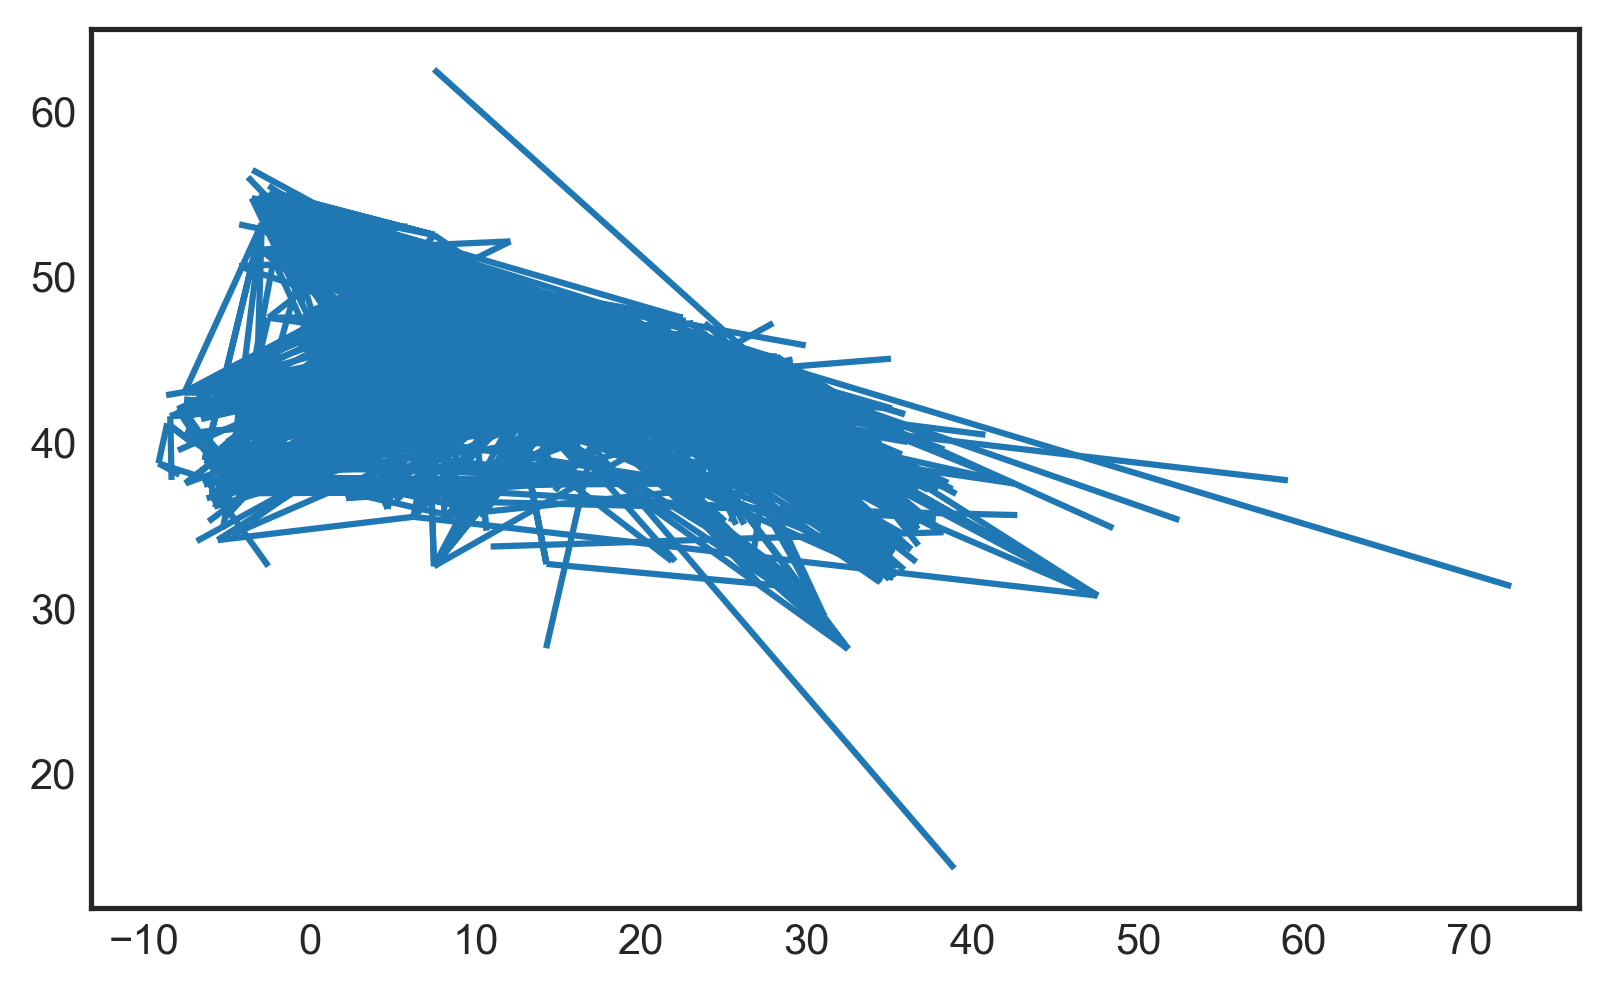

In [27]:
origo_geo.set_geometry('origo_line').plot()

In [28]:
origo_geo.set_geometry('origo_line', inplace=True)

# Minimal animation with lines

In [29]:
year = 100
keep = 50
list_subset = origo_geo[(origo_geo["random_date"]<=year) & (origo_geo["random_date"]>year-keep)]
list_subset

Unnamed: 0           id     hd_nr              origo   origo_clean  \
7          19634   HD017830/1  HD017830     [---] Classe+?  [---] Classe   
54         87024   HD075526/1  HD075526              Acele         Acele   
74         19178  HD017350/27  HD017350             Aequo*         Aequo   
76         60654   HD055677/1  HD055677            Aequo+*         Aequo   
77         86973   HD075470/1  HD075470             Aequo*         Aequo   
...          ...          ...       ...                ...           ...   
2540       87608   HD075907/1  HD075907    civi Viromanduo    Viromanduo   
2541       87612   HD075908/1  HD075908    civi Viromanduo    Viromanduo   
2551       61034   HD056196/1  HD056196             Viruno        Viruno   
2553       87464   HD075829/1  HD075829             Viruno        Viruno   
2554       89035   HD077439/1  HD077439  Viruni (= Viruno)        Viruno   

      pleiades_id pleiades_title_list  pleiades_Latitude  pleiades_Longitude  \
7        393404.0                 NaN          44.395293           12.219389   
54       393357.0                 NaN          45.796556           11.913454   
74       197095.0                 NaN          43.739278           16.655704   
76       197095.0                 NaN          43.739278           16.655704   
77       197095.0                 NaN          43.739278           16.655704   
...           ...                 ...                ...                 ...   
2540     109437.0                 NaN          49.934411            3.550822   
2541     109437.0                 NaN          49.934411            3.550822   
2551     197583.0                 NaN          46.699615           14.364777   
2553     197583.0                 NaN          46.699615           14.364777   
2554     197583.0                 NaN          46.699615           14.364777   

     pleiades_title  ... Unnamed: 24 Unnamed: 25 Unnamed: 26  \
7           Classis  ...         NaN         NaN         NaN   
54           Acelum  ...         NaN         NaN         NaN   
74           Aequum  ...         NaN         NaN         NaN   
76           Aequum  ...         NaN         NaN         NaN   
77           Aequum  ...         NaN         NaN         NaN   
...             ...  ...         ...         ...         ...   
2540     Virumandui  ...         NaN         NaN         NaN   
2541     Virumandui  ...         NaN         NaN         NaN   
2551        Virunum  ...         NaN         NaN         NaN   
2553        Virunum  ...         NaN         NaN         NaN   
2554        Virunum  ...         NaN         NaN         NaN   

                              origo_point                   geometry  \
7      POINT (12.219388845 44.3952925594)  POINT (12.21939 44.39529)   
54         POINT (11.9134537 45.79655645)  POINT (11.91345 45.79656)   
74            POINT (16.655704 43.739278)  POINT (16.65570 43.73928)   
76            POINT (16.655704 43.739278)  POINT (16.65570 43.73928)   
77            POINT (16.655704 43.739278)  POINT (16.65570 43.73928)   
...                                   ...                        ...   
2540  POINT (3.55082231128 49.9344113947)   POINT (3.55082 49.93441)   
2541  POINT (3.55082231128 49.9344113947)   POINT (3.55082 49.93441)   
2551        POINT (14.3647773 46.6996149)  POINT (14.36478 46.69961)   
2553        POINT (14.3647773 46.6996149)  POINT (14.36478 46.69961)   
2554        POINT (14.3647773 46.6996149)  POINT (14.36478 46.69961)   

                    edh_point random_date not_before not_after  \
7     POINT (12.1422 43.9194)        89.0       50.0       1.0   
54     POINT (8.2674 49.9951)        51.0       43.0     -13.0   
74    POINT (27.9423 44.0928)        93.0       90.0      87.0   
76     POINT (8.2674 49.9951)        93.0       86.0      70.0   
77     POINT (8.2674 49.9951)        90.0       86.0      70.0   
...                       ...         ...        ...       ...   
2540    POINT (6.868 51.0651)       

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
MovieWriter ffmpeg unavailable; using Pillow instead.


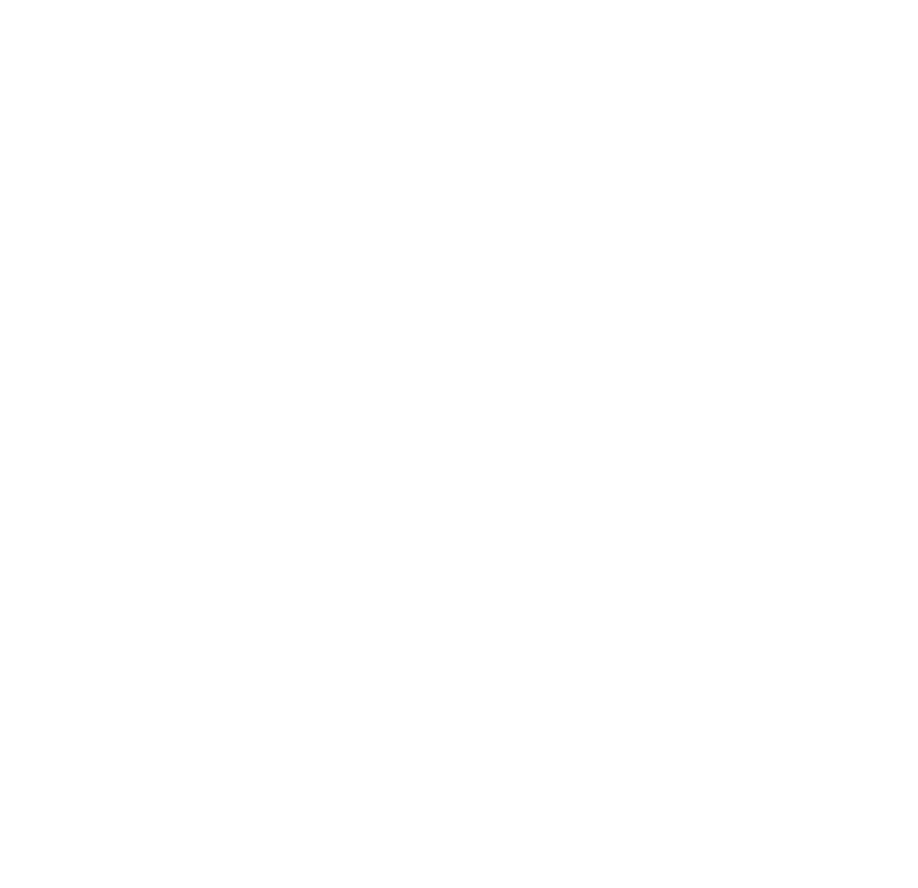

In [22]:
keep=50

fig = plt.figure(figsize=(5.2, 3), dpi=300, tight_layout=True)
ax = plt.axes()
ax.set_axis_off()
ax.set_xlim(-10,45)


camera = Camera(fig)
for year in range(-100, 400, 5):
    gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
    list_subset = origo_geo[(origo_geo["random_date"]<=year) & (origo_geo["random_date"]>year-keep)]
    list_subset.plot(ax=ax)
    ax.text(30,55, str(year), fontsize=6, color="black")
    camera.snap()
animation = camera.animate()
animation.save('../data/anim1_lines.gif')

# Lines into points

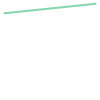

In [30]:
line = origo_geo["origo_line"].values[0] #should work also with paths, not only direct lines
line

In [31]:
type(line)

shapely.geometry.linestring.LineString

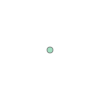

In [32]:
line.interpolate(0.9)

In [33]:
interpolated = MultiPoint([line.interpolate((i/10), normalized=True) for i in range(1, 10)])

In [34]:
n_segments = 100
segments = [LineString([line.interpolate((i/n_segments), normalized=True), line.interpolate((i+1/n_segments), normalized=True)]) for i in range(0, n_segments)]
cm = plt.get_cmap('coolwarm')
color_vals = list(cm([val/n_segments for val in range(n_segments)]))

In [35]:
segments_df = gpd.GeoDataFrame({"geometry": segments, "color" : color_vals})

<Axes: >

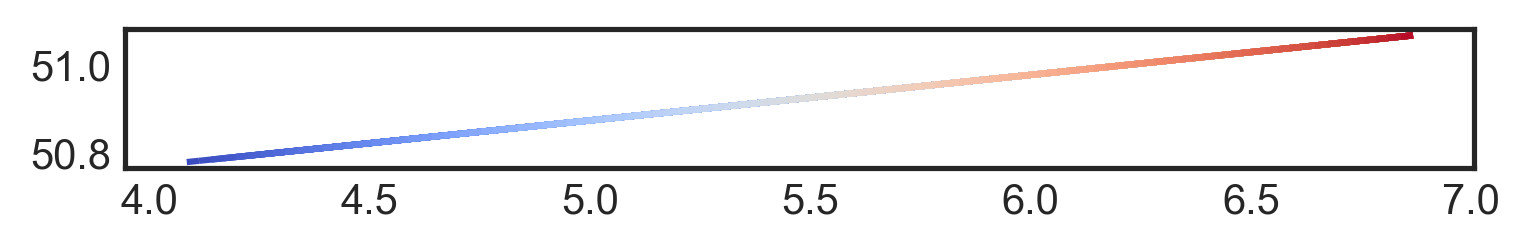

In [36]:
fig = plt.figure(figsize=(5.2, 3), dpi=300, tight_layout=True)
ax = plt.axes()

segments_df.plot(color=segments_df["color"], ax=ax)

# point data with random color and fast beginning and end

In [37]:
origo_geo["random_date"] = origo_geo["random_date"].astype(int)

In [38]:
origo_points_list = []
step_len = 5
age = 50
for n in range(len(origo_geo)):
    line = origo_geo.iloc[n]["origo_line"]
    year = origo_geo.iloc[n]["random_date"]
    color = random.choice(list(mcolors.TABLEAU_COLORS.keys()))
    dates = range(year-age+step_len,year+step_len, step_len)
    for i,y in enumerate(dates):
        data = {
            "date": y,
            "geometry" : Point(line.interpolate((i/len(dates)), normalized=True)),
            "color" : color
        }
        origo_points_list.append(data)

# point data with random color with waiting at the beginning and end


In [39]:
n = 0
line = origo_geo.iloc[n]["origo_line"]
line = origo_geo.iloc[n]["origo_line"]
year = origo_geo.iloc[n]["random_date"]
color = random.choice(list(mcolors.TABLEAU_COLORS.keys()))
dates = range(year-age+step_len,year+step_len, step_len)
print(Point(line.interpolate(0.12, normalized=True)))

POINT (4.418756204452 50.812006359288)


In [40]:
[Point(line.interpolate((i/(len(dates)-2)), normalized=True)) for i in range(len(dates) - 2)]

In [41]:
colors = [random.choice(list(mcolors.TABLEAU_COLORS.keys()))] * len(dates)
colors

['tab:red',
 'tab:red',
 'tab:red',
 'tab:red',
 'tab:red',
 'tab:red',
 'tab:red',
 'tab:red',
 'tab:red',
 'tab:red']

In [42]:
all_dates = []
all_points = []
all_colors = []
step_len = 5
age = 50
for n in range(len(origo_geo)):
    line = origo_geo.iloc[n]["origo_line"]
    year = origo_geo.iloc[n]["random_date"]
    colors = [random.choice(list(mcolors.TABLEAU_COLORS.keys()))] * len(dates)
    dates = range(year-age+step_len,year+step_len, step_len)
    points = [Point(line.interpolate((i/(len(dates)-3)), normalized=True)) for i in range(len(dates) - 2)]
    points = [origo_geo.iloc[n]["origo_point"]] + points +  [origo_geo.iloc[n]["edh_point"]]
    all_dates.extend(dates)
    all_points.extend(points)
    all_colors.extend(colors)

In [43]:
origo_linepoints_gdf = gpd.GeoDataFrame({"date" : all_dates, "geometry" : all_points, "color" : all_colors})
origo_linepoints_gdf

date                   geometry     color
0       374   POINT (4.08477 50.77749)   tab:red
1       379   POINT (4.08477 50.77749)   tab:red
2       384   POINT (4.48237 50.81858)   tab:red
3       389   POINT (4.87998 50.85967)   tab:red
4       394   POINT (5.27758 50.90075)   tab:red
...     ...                        ...       ...
22765   -67   POINT (9.39828 43.55647)  tab:pink
22766   -62  POINT (10.42759 43.00154)  tab:pink
22767   -57  POINT (11.45689 42.44662)  tab:pink
22768   -52  POINT (12.48620 41.89170)  tab:pink
22769   -47  POINT (12.48620 41.89170)  tab:pink

[22770 rows x 3 columns]

MovieWriter ffmpeg unavailable; using Pillow instead.


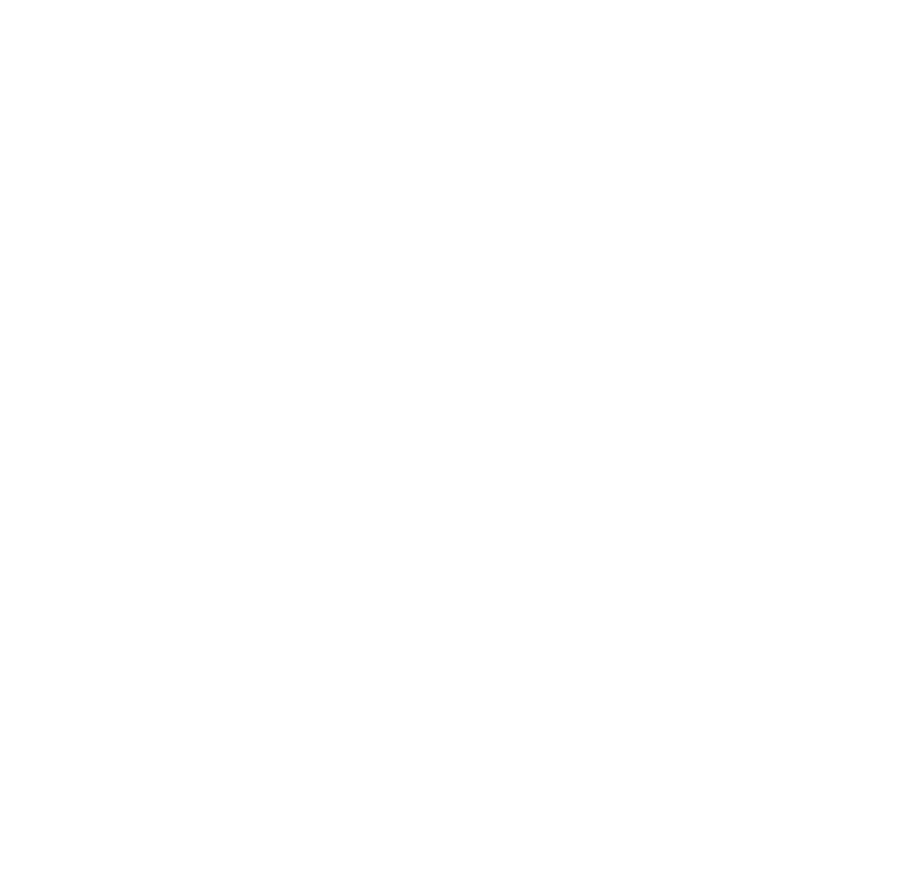

In [44]:
fig = plt.figure(figsize=(5.2, 3), dpi=300, tight_layout=True)
ax = plt.axes()
ax.set_axis_off()
ax.set_xlim(-10,45)
step = 5

camera = Camera(fig)
for year in range(-50, 450, step):
    gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
    list_subset = origo_linepoints_gdf[origo_linepoints_gdf["date"].between(year-4, year)]
    list_subset.plot(ax=ax, markersize=1, color=list_subset["color"])
    ax.text(30,55, str(year), fontsize=6, color="black")
    camera.snap()
animation = camera.animate()
animation.save('../data/anim1_linepoints.gif')

# Data for background lines

<Axes: >

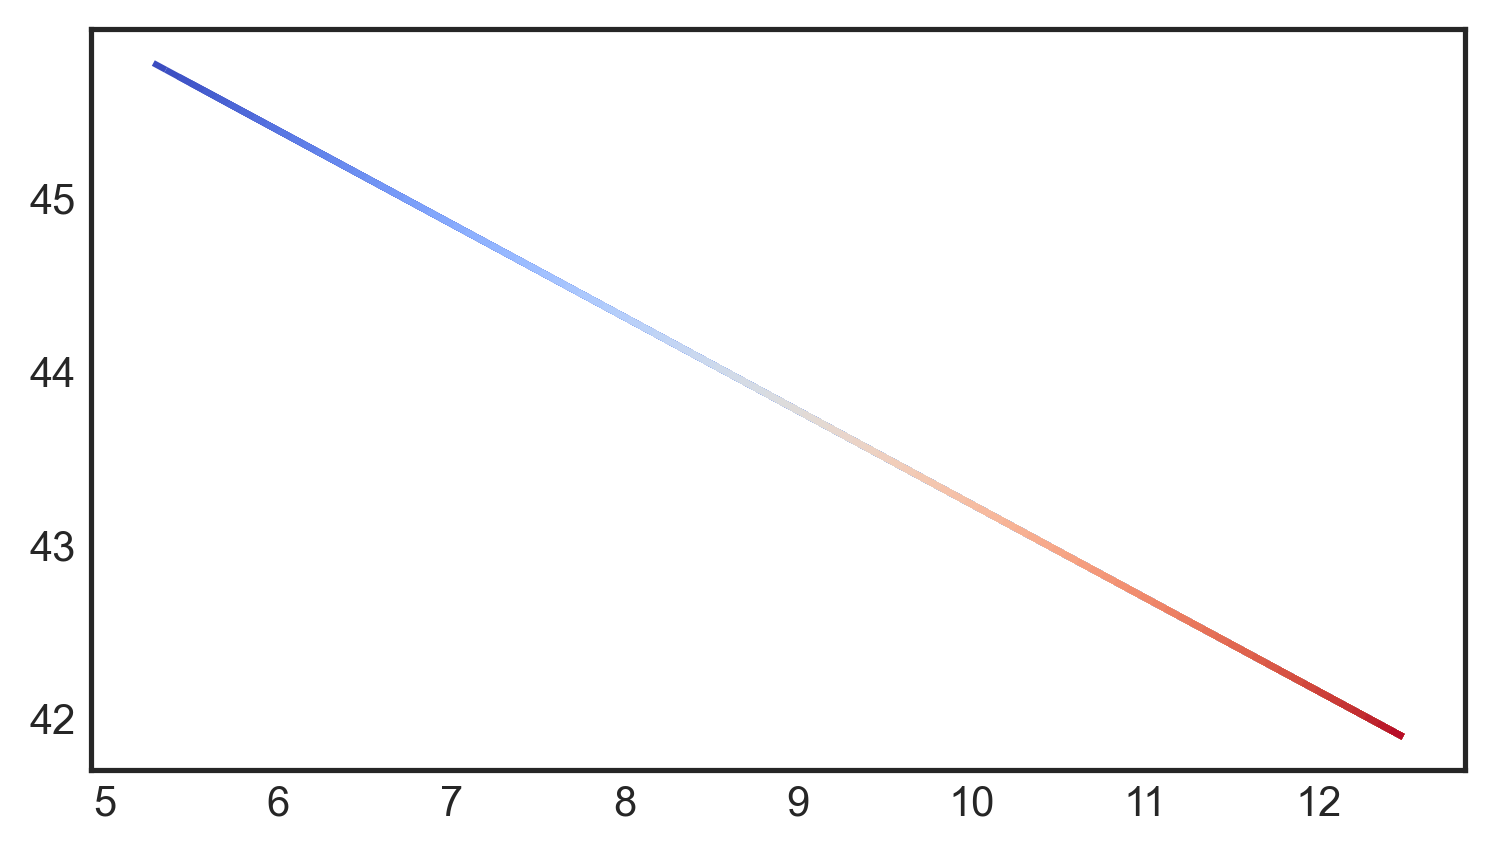

In [45]:
n_segments = 100
segments = [LineString(
    [line.interpolate((i / n_segments), normalized=True), line.interpolate((i + 1 / n_segments), normalized=True)]) for
            i in range(0, n_segments)]
cm = plt.get_cmap('coolwarm')
color_vals = list(cm([val / n_segments for val in range(n_segments)]))
segments_df = gpd.GeoDataFrame({"geometry": segments, "color": color_vals})
fig = plt.figure(figsize=(5.2, 3), dpi=300, tight_layout=True)
ax = plt.axes()

segments_df.plot(color=segments_df["color"], ax=ax)

In [46]:
n_segments = 50
cm = plt.get_cmap('coolwarm')
color_vals = list(cm([(val / n_segments) for val in range(n_segments)]))

In [47]:
len(origo_geo)

2277

In [48]:
n_segments = 50
all_years = []
all_segments = []
all_colors = []
all_notbefores = []
all_notafters = []
for n in range(len(origo_geo)):
    line = origo_geo.iloc[n]["origo_line"]
    segments = [LineString([line.interpolate((i / n_segments), normalized=True), line.interpolate(((i + 1) / n_segments), normalized=True)]) for i in range(0, n_segments)]
    years = [origo_geo.iloc[n]["random_date"]] * len(segments)
    notbefores = [origo_geo.iloc[n]["not_before"]] * len(segments)
    notafters = [origo_geo.iloc[n]["not_after"]] * len(segments)
    # merge together
    all_years.extend(years)
    all_notbefores.extend(notbefores)
    all_notafters.extend(notafters)
    all_segments.extend(segments)
    all_colors.extend(color_vals)

segmentlines_df = gpd.GeoDataFrame({"year": all_years,
                                    "not_before" : all_notbefores,
                                    "not_after" : all_notafters,
                                    "color" : all_colors,
                                    "geometry" : all_segments})

<Axes: >

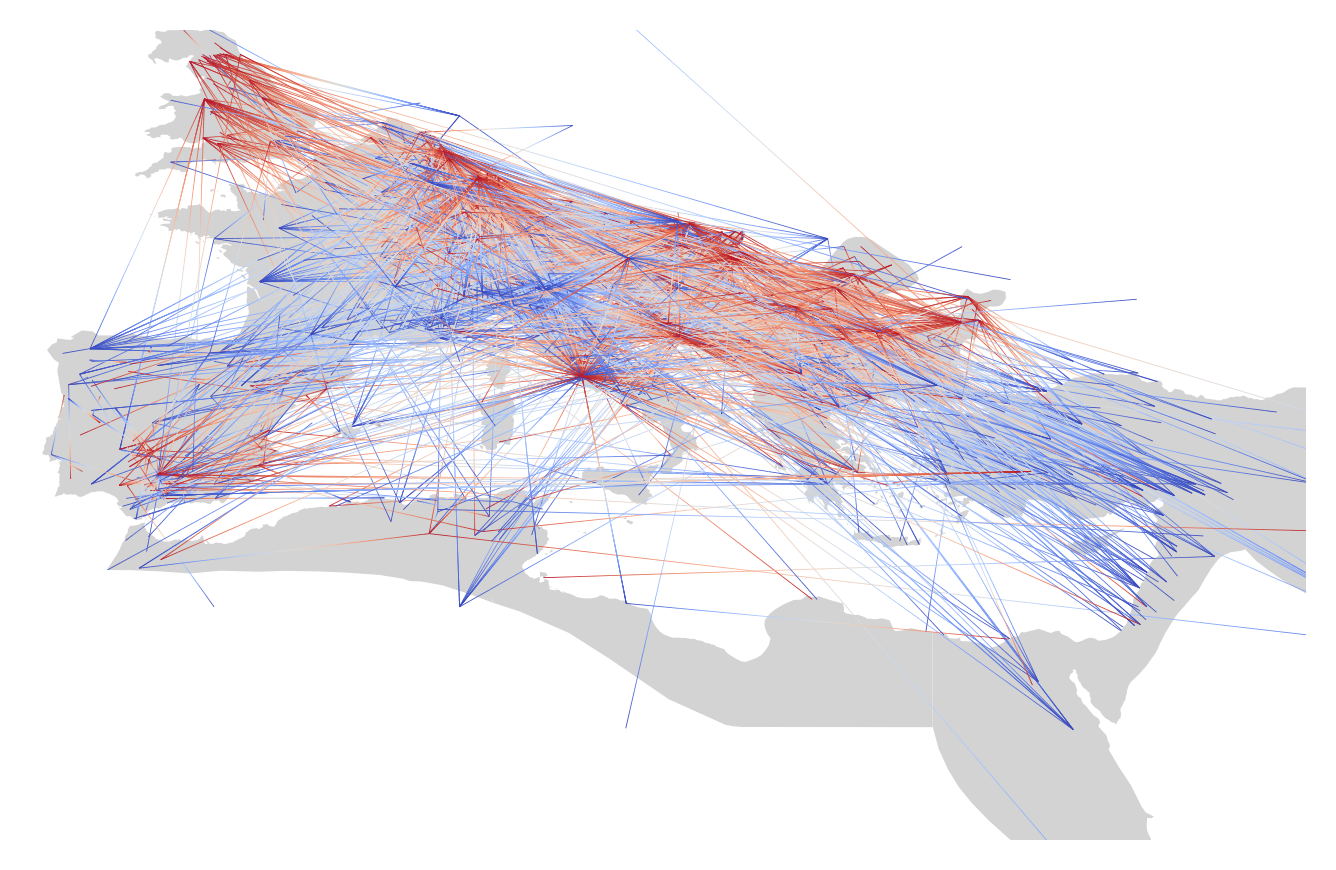

In [ ]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
#GIST.plot()
ax.set_xlim(-10, 42)
ax.set_ylim(23, 56)

ax.set_axis_off()
segmentlines_df.plot(color=segmentlines_df["color"], linewidth=0.2, ax=ax)

In [57]:
def within_period(row, period_start, period_end):
    try:
        return (period_start <= row["not_before"] <= period_end) | (period_end >= row["not_after"] >= period_start)
    except:
        return False

In [58]:
cents = [("1BCE", (-100,-1)), ("1CE", (1,100)), ("2CE", (101,200)), ("3CE",(201,300)) , ("4CE", (301,400)), ("5CE", (401,500))]
for cent_tup in cents:
    origo_geo[cent_tup[0]] = origo_geo.apply(lambda row: within_period(row, period_start=cent_tup[1][0], period_end=cent_tup[1][1]), axis=1)
    segmentlines_df[cent_tup[0]] = segmentlines_df.apply(lambda row: within_period(row, period_start=cent_tup[1][0], period_end=cent_tup[1][1]), axis=1)

In [59]:
len(origo_geo[origo_geo["1CE"]])

1098

In [60]:
origo_geo = origo_geo.set_geometry("edh_point")

In [61]:
origo_geo[['id', 'hd_nr', 'origo', 'origo_clean', 'pleiades_id',
           'pleiades_title_list', 'pleiades_Latitude', 'pleiades_Longitude',
           'pleiades_title', 'Certainty', 'edh_point', 'origo_point', 'origo_line',
           'random_date', 'not_before', 'not_after',  '1BCE', '1CE',
           '2CE', '3CE', '4CE', '5CE']]#%%

id     hd_nr                          origo  \
0       HD075902/1  HD075902    cives(!) (= civis) Nervius+   
1       HD081444/1  HD081444            natione(?)Pannonius   
2       HD056833/3  HD056833        cives(= civis) Convena*   
3       HD018231/1  HD018231  cives(= civis) Veliocassinius   
4       HD010286/1  HD010286    natione+* [---] Aelia [---]   
...            ...       ...                            ...   
2564  HD032316/128  HD032316                        Zerna*?   
2566    HD037345/1  HD037345                 natione Zoela!   
2589    HD056506/2  HD056506                        Ἐφέσιος   
2607    HD025474/5  HD025474                       Μιλήσιος   
2637    HD008584/6  HD008584                  natione verna   

              origo_clean  pleiades_id pleiades_title_list  pleiades_Latitude  \
0         () (= ) Nervius     109199.0                 NaN          50.777494   
1             ()Pannonius     992076.0                 NaN          47.500000   
2            (= ) Convena     246357.0                 NaN          42.966682   
3     (= ) Veliocassinius     109412.0                 NaN          49.364001   
4       [---] Aelia [---]     197389.0                 NaN          45.560018   
...                   ...          ...                 ...                ...   
2564                Zerna     207078.0                 NaN          44.731710   
2566                Zoela     236724.0                 NaN          41.717349   
2589              Ἐφέσιος     599612.0                 NaN          37.940762   
2607             Μιλήσιος     599799.0                 NaN          37.522905   
2637                  NaN     167964.0                 NaN          45.776152   

      pleiades_Longitude       pleiades_title  \
0               4.084768               Nervii   
1              12.500000            Pannoniae   
2               0.269919             Convenae   
3               0.831097          Veliocasses   
4              18.675749                Mursa   
...                  ...                  ...   
2564           22.401909               Dierna   
2566           -6.628006               Zoelae   
2589           27.340307  Ephesus/Arsinoe(ia)   
2607           27.278317              Miletus   
2637            5.281057               Vernas   

                                              Certainty  ...  \
0                                               certain  ...   
1     uncertain (name could be interpreted differently)  ...   
2                                               certain  ...   
3                                               certain  ...   
4     uncertain (name could be interpreted differently)  ...   
...                                                 ...  ...   
2564                                            certain  ...   
2566                                            certain  ...   
2589                                            certain  ...   
2607                                            certain  ...   
2637                                         wild guess  ...   

                                             origo_line random_date  \
0       LINESTRING (4.08477 50.77749, 6.86800 51.06510)         419   
1     LINESTRING (12.50000 47.50000, -0.20880 51.46410)         499   
2       LINESTRING (0.26992 42.96668, 2.09200 41.38390)         107   
3       LINESTRING (0.83110 49.36400, 3.87770 51.61560)         339   
4     LINESTRING (18.67575 45.56002, 12.48620 41.89170)         210   
...                                                 ...         ...   
2564  LINESTRING (22.40191 44.73171, 21.17510 44.72200)         195   
2566  LINESTRING (-6.62801 41.71735, 18.93680 46.97550)         115   
2589  LINESTRING (27.34031 37.94076, 25.16340 37.53750)         -50   
2607  LINESTRING (27.27832 37.52290, 30.83930 29.31210)         151   
2637   LINESTRING (5.28106 45.77615, 12.48620 41.89170)         -47   

     not_before  not_after   1BCE    1CE    2CE    3CE    4CE    5CE  
0   

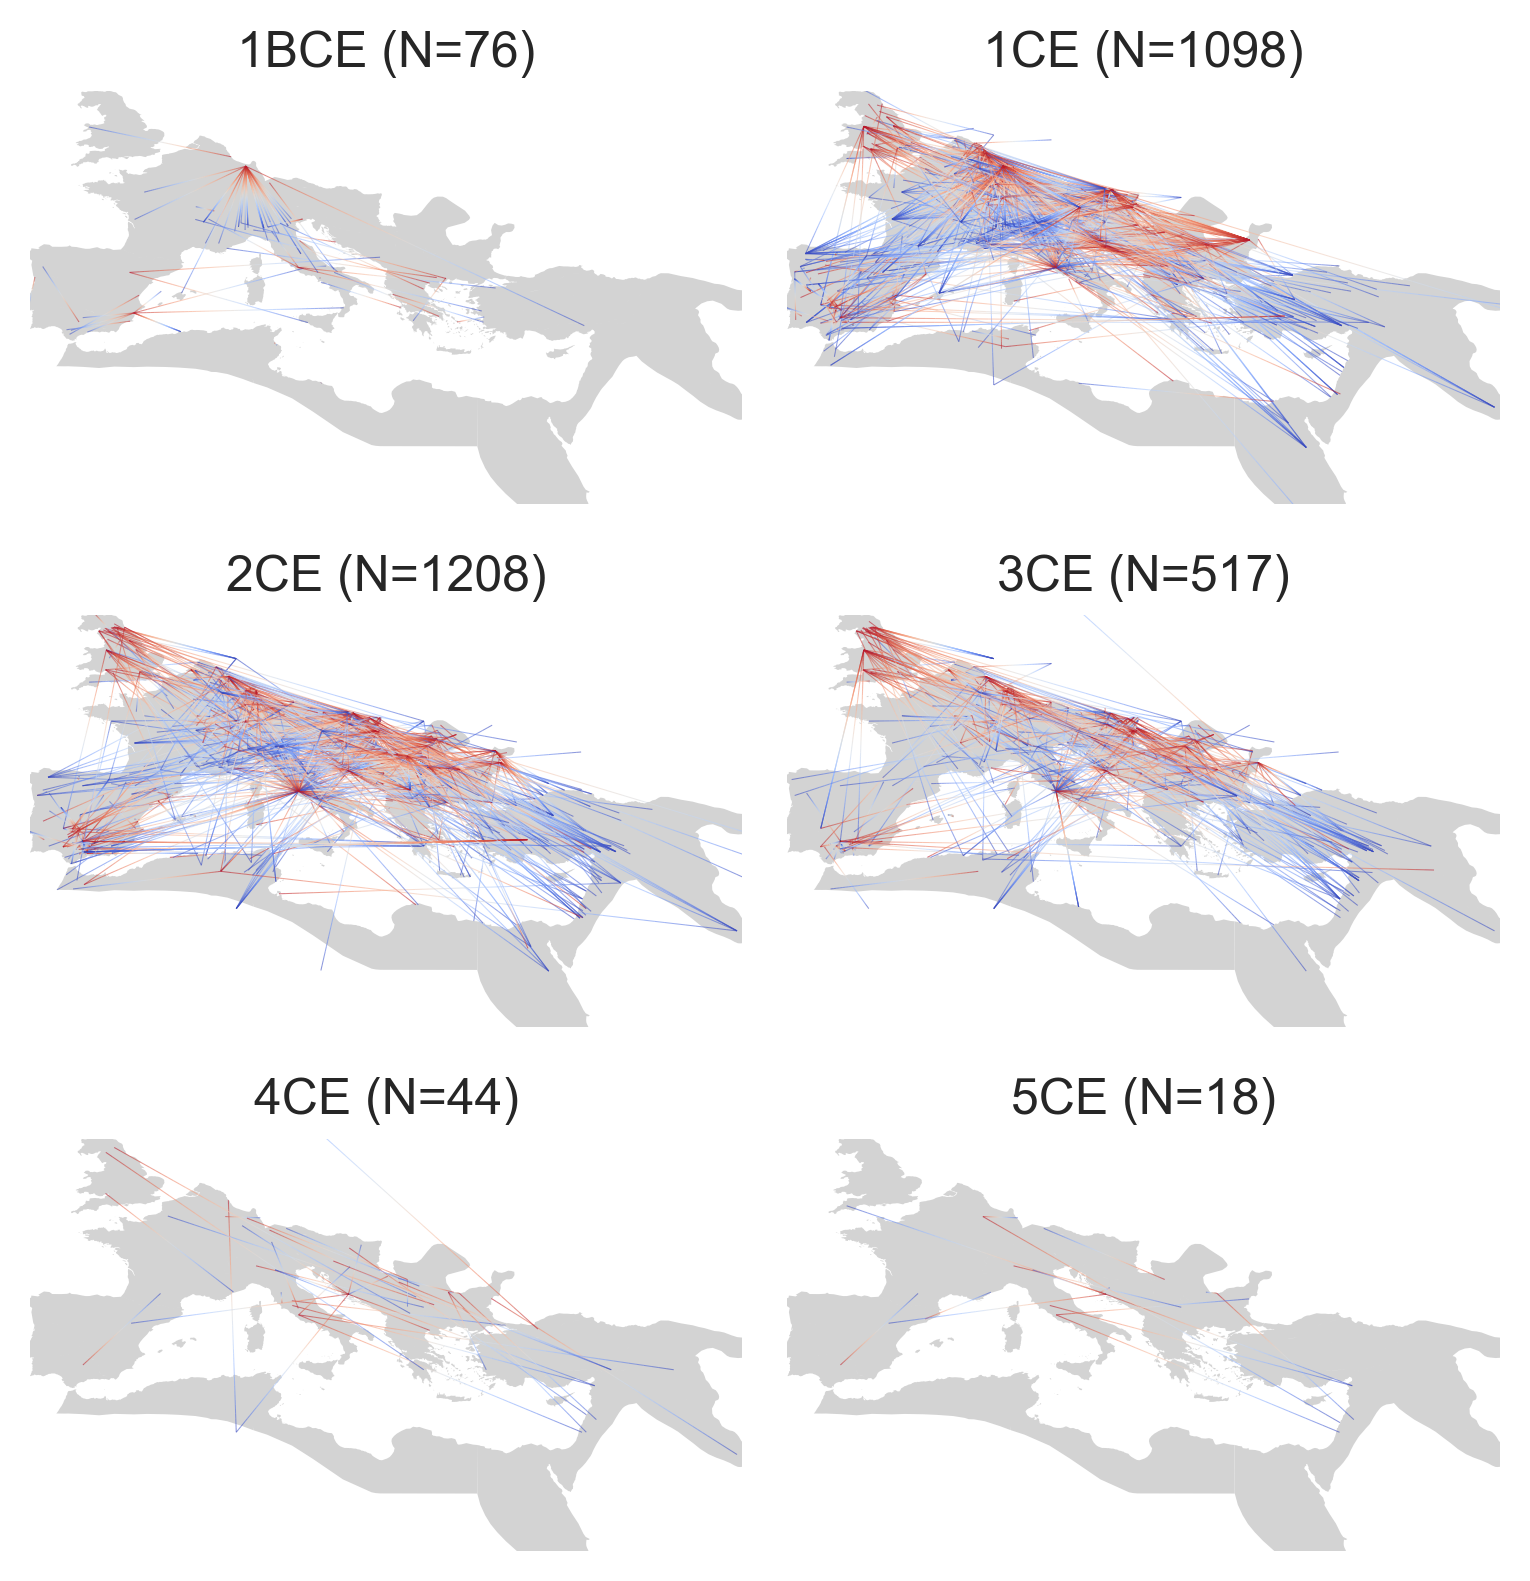

In [65]:
fig, axs = plt.subplots(3,2, figsize=(5.2, 6), dpi=300, tight_layout=True)

for ax, cent_tup in zip(axs.ravel(), cents):
    gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
    #GIST.plot()
    ax.set_xlim(-9, 48)
    ax.set_ylim(23, 56)
    ax.set_axis_off()
    N = origo_geo[cent_tup[0]].sum()
    ax.set_title(cent_tup[0] + " (N={})".format(str(N)))
    segmentlines_df[segmentlines_df[cent_tup[0]]].plot(color=segmentlines_df["color"], linewidth=0.25, alpha=0.6, ax=ax)

In [ ]:
save_figure(fig, "century_snapshots_6cents")

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(5.2, 4), dpi=300, tight_layout=True)

for ax, cent_tup in zip(axs.ravel(), cents[:4]):
    gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
    #GIST.plot()
    ax.set_xlim(-10, 42)
    ax.set_ylim(23, 56)
    ax.set_axis_off()
    N = origo_geo[cent_tup[0]].sum()
    ax.set_title(cent_tup[0] + " (N={})".format(str(N)))
    segmentlines_df[segmentlines_df[cent_tup[0]]].plot(color=segmentlines_df["color"], linewidth=0.25, alpha=0.6, ax=ax)

In [ ]:
save_figure(fig, "century_snapshots_4cents")

In [ ]:
keep=50

fig = plt.figure(figsize=(5.2, 3), dpi=300, tight_layout=True)
ax = plt.axes()
ax.set_axis_off()
ax.set_xlim(-10,45)

camera = Camera(fig)
for year in range(100, 200, 5):
    gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
    list_subset = segmentlines_df[(segmentlines_df["year"]<=year) & (segmentlines_df["year"]>year-keep)]
    list_subset.plot(ax=ax, color=list_subset["color"], linewidth=0.2)
    ax.text(30,55, str(year), fontsize=6, color="black")
    camera.snap()
animation = camera.animate()
animation.save('../data/anim3_linesegments.gif')

# Points with changing color

In [ ]:
points_n = 10
line = origo_geo.iloc[0]["origo_line"]
print(line)

In [ ]:
print(Point(line.interpolate(1, normalized=True)))

In [ ]:
points = [Point(line.interpolate((i / (points_n-1)), normalized=True)) for i in range(0,points_n)]
for point in points:
    print(point)

In [ ]:
markersizes = np.ones(10)
markersizes[0], markersizes[-1] = 3, 3

In [ ]:
points_n = 50
cm = plt.get_cmap('coolwarm')
colors = list(cm([1 - (val / points_n) for val in range(points_n)]))
colors = list(cm([val / points_n for val in range(points_n)]))
markersizes = np.ones(points_n)
markersizes[0], markersizes[-1] = 3, 3
all_dates = []
all_points = []
all_colors = []
all_markersizes = []
step_len = 1
age = 50
for n in range(len(origo_geo)):
    line = origo_geo.iloc[n]["origo_line"]
    year = origo_geo.iloc[n]["random_date"]
    dates = range(year - age + step_len, year + step_len, step_len)
    points = [Point(line.interpolate((i / (points_n-1)), normalized=True)) for i in range(0,points_n)]
    all_dates.extend(dates)
    all_points.extend(points)
    all_colors.extend(colors)
    all_markersizes.extend(markersizes)
origo_linepoints_gdf = gpd.GeoDataFrame({"date": all_dates, "geometry": all_points, "color": all_colors, "markersize" : all_markersizes})
origo_linepoints_gdf

In [ ]:
len(origo_linepoints_gdf)

In [ ]:
origo_linepoints_gdf.to_parquet("../data/origo_linepoints_gdf.parquet")

In [ ]:
year = 50
keep = 50
segmentlines_subset = segmentlines_df[(segmentlines_df["year"]>=year) & (segmentlines_df["year"]<year+keep)]
segmentlines_subset

In [ ]:
%%time
keep=50

fig = plt.figure(figsize=(5.2, 3), dpi=300, tight_layout=True)
ax = plt.axes()
ax.set_axis_off()
ax.set_xlim(-10,45)


camera = Camera(fig)
for year in range(-100, 500, 2):
    # lines
    gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
    segmentlines_subset = segmentlines_df[(segmentlines_df["year"]>=year) & (segmentlines_df["year"]<year+keep)]
    segmentlines_subset.plot(ax=ax, color=segmentlines_subset["color"], linewidth=0.2)
    # moving points
    linepoints_subset = origo_linepoints_gdf[origo_linepoints_gdf["date"]==year]
    linepoints_subset.plot(ax=ax, color=linepoints_subset["color"], markersize=linepoints_subset["markersize"])
    # staying dots
    sourcedest_subset = origo_geo[origo_geo["random_date"]<=year]
    sourcedest_subset.set_geometry("origo_point").plot(color="darkblue", markersize=1, alpha=0.3, ax=ax)
    sourcedest_subset.set_geometry("edh_point").plot(color="darkred", markersize=1, alpha=0.3, ax=ax)
    ax.text(30,55, str(year), fontsize=12, color="black")
    camera.snap()
animation = camera.animate()
animation.save('../data/anim4_linesegments+points_march23.gif')

# Network of provinces

In [ ]:
provinces = gpd.read_file("../data/roman_province_boundaries.json")
#provinces = provinces.to_crs("EPSG:4326")
len(provinces)

In [ ]:
pleiades_regions

In [ ]:
origo_geo = origo_geo.set_geometry('edh_point')
origo_geo.crs = "EPSG:4326"

In [ ]:
points_in_polygons = gpd.sjoin(origo_geo, provinces, how="left", op="within")

In [ ]:
points_in_polygons

In [ ]:
provinces[1:10]

In [ ]:
origo_geo.within(provinces.geometry[0]).sum()

In [ ]:
provinces["province"]

In [ ]:
for province_geo, province_name in zip(provinces.geometry, provinces["province"]):
    try:
        origo_geo.within(province_geo)


    origo_geo["edh_point"].to_crs("EPSG:4326")

In [ ]:
data = origo_geo["origo_point"].within(provinces)
data

In [ ]:
provinces.plot(linewidth=4)

# On Orbis network

In [ ]:
G = nx.read_graphml("../data/orbis_network_enriched.graphml")

In [ ]:
G.edges(data=True)

# Adela's data

In [ ]:
orig_dest155 = gpd.read_file("../data/orig_dest155.geojson", driver="GeoJSON")

In [ ]:
orig_dest155.plot()

In [ ]:
# - start with simple space-abstracted animation of dots moving from origo to destintion
# - in a next step, we will move it to Orbis


In [ ]:
origo_points_list = []
step_len = 5
age = 50
for n in range(len(origo_geo)):
    line = origo_geo.iloc[n]["origo_line"]
    year = origo_geo.iloc[n]["random_date"]
    color = random.choice(list(mcolors.TABLEAU_COLORS.keys()))
    dates = range(year-age+step_len,year+step_len, step_len)
    for i,y in enumerate(dates):
        data = {
            "date": y,
            "geometry" : Point(line.interpolate((i/len(dates)), normalized=True)),
            "color" : color
        }
        origo_points_list.append(data)

In [ ]:
origo_geo

In [ ]:
gpd.GeoDataFrame(origo_points_list)

In [ ]:
origo_points_list

In [ ]:
n = 0
line = origo_geo.iloc[n]["origo_line"]
line = origo_geo.iloc[n]["origo_line"]
year = origo_geo.iloc[n]["random_date"]
color = random.choice(list(mcolors.TABLEAU_COLORS.keys()))
dates = range(year-age+step_len,year+step_len, step_len)
print(Point(line.interpolate(0.12, normalized=True)))

In [ ]:
[Point(line.interpolate((i/(len(dates)-2)), normalized=True)) for i in range(len(dates) - 2)]

In [ ]:
[Point(line.split((i/(len(dates)-2)), normalized=True)) for i in range(len(dates) - 2)]


In [ ]:
colors = [random.choice(list(mcolors.TABLEAU_COLORS.keys()))] * len(dates)
colors

In [ ]:
all_dates = []
all_points = []
all_colors = []
step_len = 5
age = 50
for n in range(len(origo_geo)):
    line = origo_geo.iloc[n]["origo_line"]
    year = origo_geo.iloc[n]["random_date"]
    colors = [random.choice(list(mcolors.TABLEAU_COLORS.keys()))] * len(dates)
    dates = range(year-age+step_len,year+step_len, step_len)
    points = [Point(line.interpolate((i/(len(dates)-3)), normalized=True)) for i in range(len(dates) - 2)]
    points = [origo_geo.iloc[n]["origo_point"]] + points +  [origo_geo.iloc[n]["edh_point"]]
    all_dates.extend(dates)
    all_points.extend(points)
    all_colors.extend(colors)

In [ ]:
origo_linepoints_gdf = gpd.GeoDataFrame({"date" : all_dates, "geometry" : all_points, "color" : all_colors})
origo_linepoints_gdf

In [ ]:
fig = plt.figure(figsize=(5.2, 3), dpi=300, tight_layout=True)
ax = plt.axes()
ax.set_axis_off()
ax.set_xlim(-10,45)
step = 5

camera = Camera(fig)
for year in range(-50, 450, step):
    gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
    list_subset = origo_linepoints_gdf[origo_linepoints_gdf["date"].between(year-4, year)]
    list_subset.plot(ax=ax, markersize=1, color=list_subset["color"])
    ax.text(30,55, str(year), fontsize=6, color="black")
    camera.snap()
animation = camera.animate()
animation.save('../data/anim1_linepoints.gif')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

In [ ]:
x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))

In [ ]:

# Create a set of line segments so that we can color them individually
# This creates the points as an N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])

# Use a boundary norm instead
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[1].add_collection(lc)
fig.colorbar(line, ax=axs[1])

axs[0].set_xlim(x.min(), x.max())
axs[0].set_ylim(-1.1, 1.1)
plt.show()

In [136]:
origo_geo.to_parquet("../data/origo_geo.parquet")

In [139]:
segmentlines_df.to_parquet("../data/segmentlines_df.parquet")

In [3]:
origo_geo = gpd.read_parquet("../data/origo_geo.parquet")
segmentlines_df = gpd.read_parquet("../data/segmentlines_df.parquet")

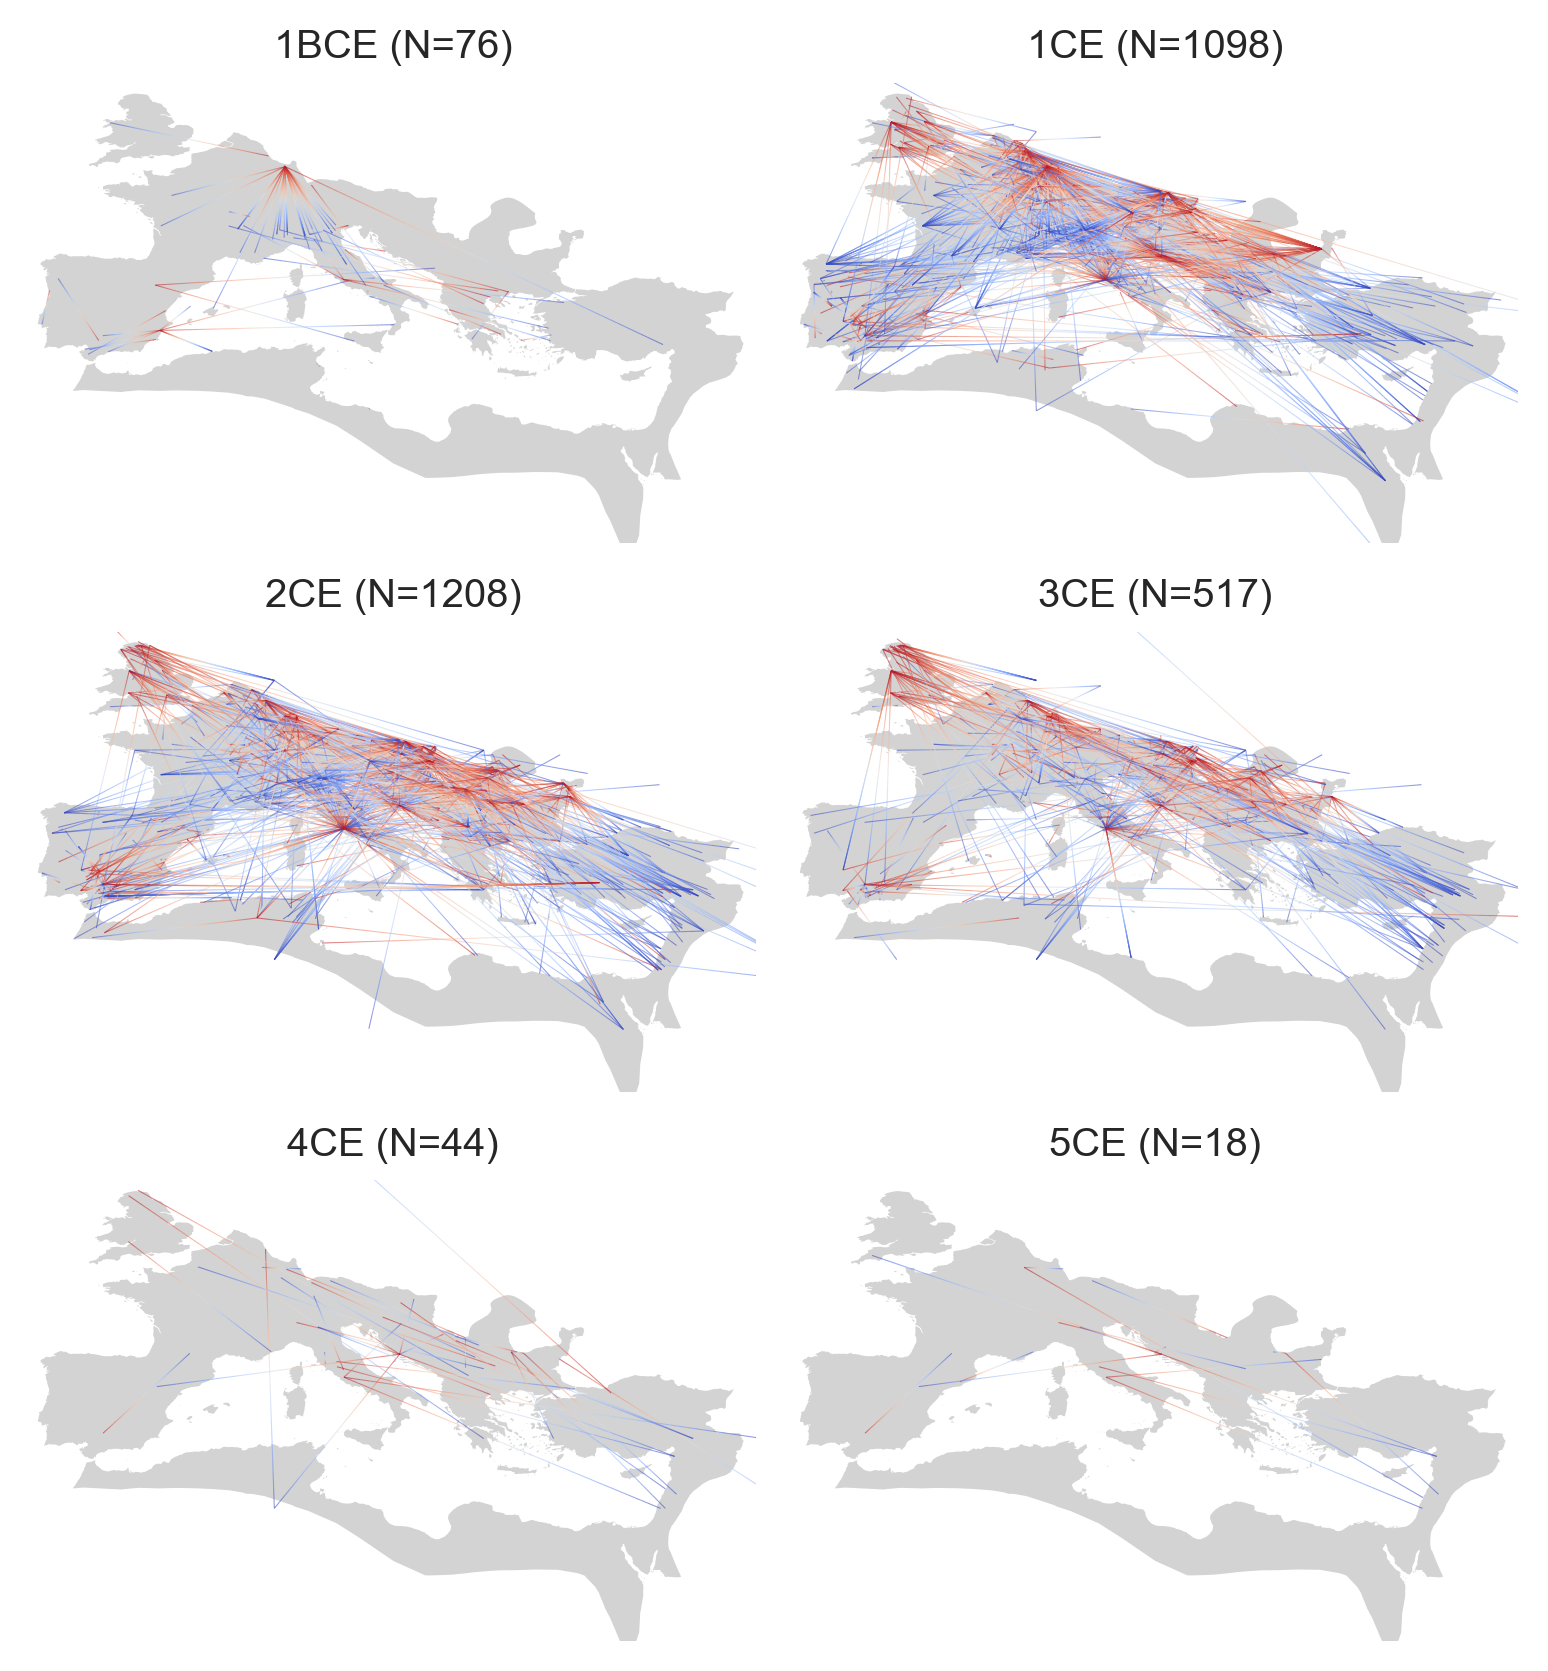

In [54]:
fig, axs = plt.subplots(3,2, figsize=(5.2, 6), dpi=300, tight_layout=True)

for ax, cent_tup in zip(axs.ravel(), cents):
    gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
    #GIST.plot()
    ax.set_xlim(-10, 42)
    ax.set_ylim(23, 56)
    ax.set_axis_off()
    N = origo_geo[cent_tup[0]].sum()
    ax.set_title(cent_tup[0] + " (N={})".format(str(N)))
    segmentlines_df[segmentlines_df[cent_tup[0]]].plot(color=segmentlines_df["color"], linewidth=0.25, alpha=0.6, ax=ax)

In [55]:
save_figure(fig, "century_snapshots_6cents")

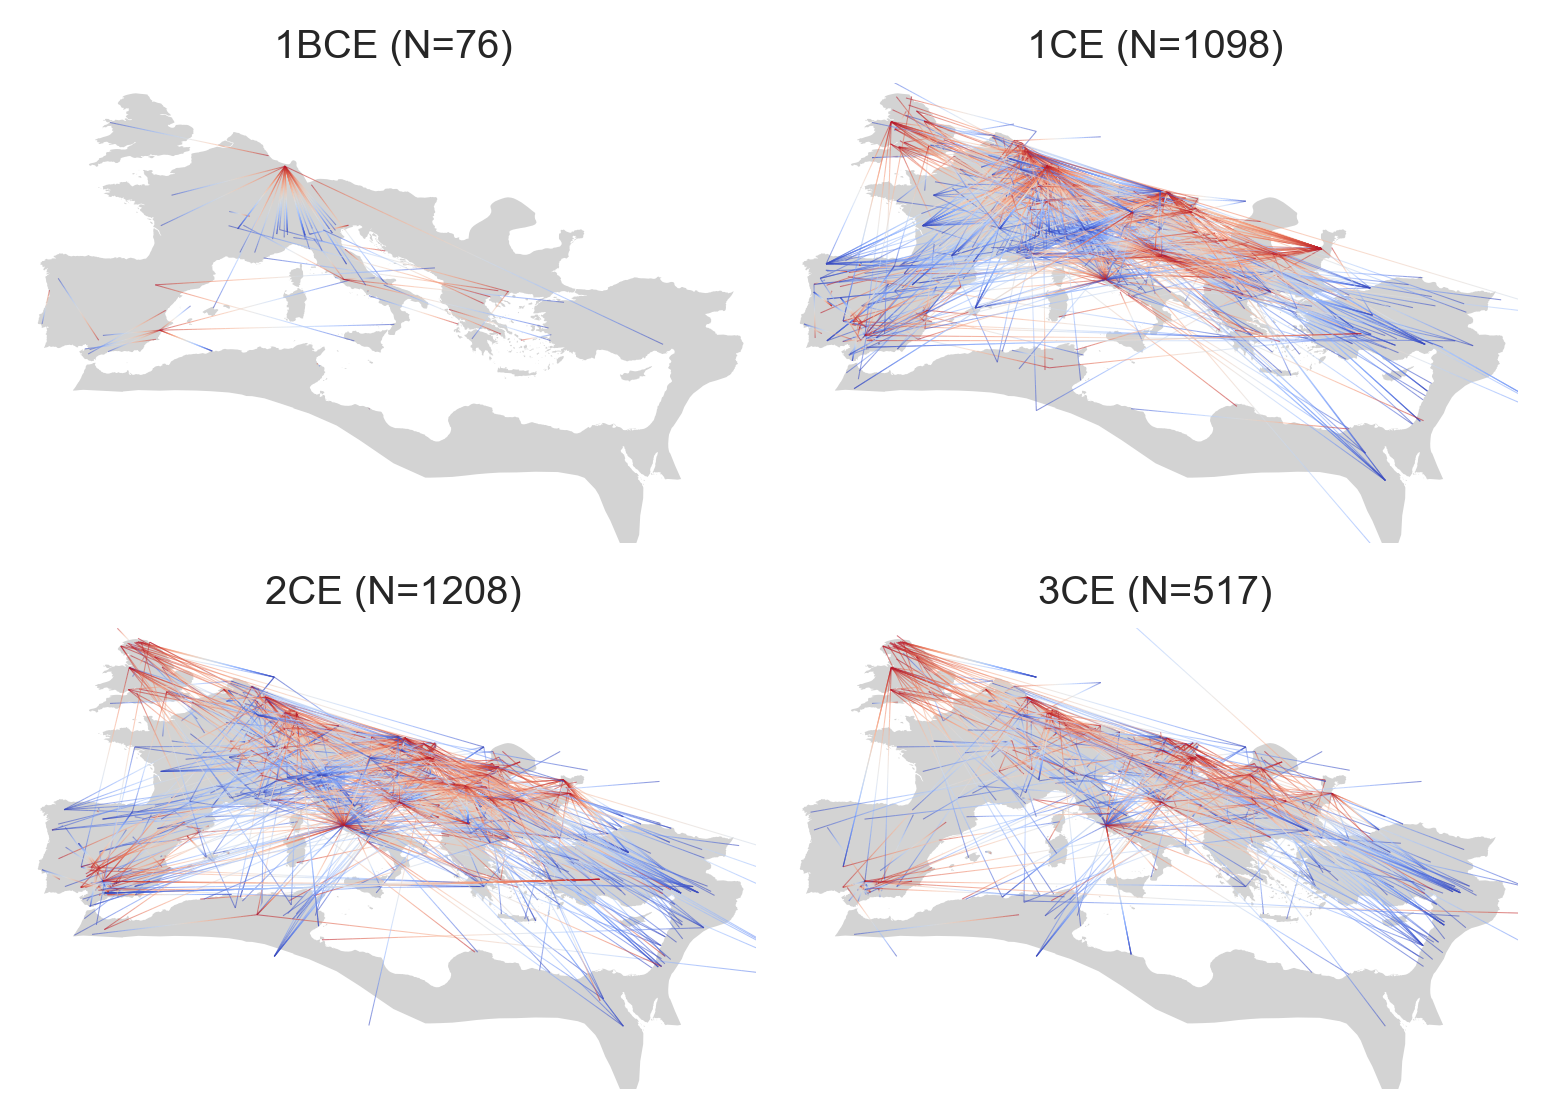

In [56]:
fig, axs = plt.subplots(2,2, figsize=(5.2, 4), dpi=300, tight_layout=True)

for ax, cent_tup in zip(axs.ravel(), cents[:4]):
    gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
    #GIST.plot()
    ax.set_xlim(-10, 42)
    ax.set_ylim(23, 56)
    ax.set_axis_off()
    N = origo_geo[cent_tup[0]].sum()
    ax.set_title(cent_tup[0] + " (N={})".format(str(N)))
    segmentlines_df[segmentlines_df[cent_tup[0]]].plot(color=segmentlines_df["color"], linewidth=0.25, alpha=0.6, ax=ax)

In [57]:
save_figure(fig, "century_snapshots_4cents")

KeyboardInterrupt: 

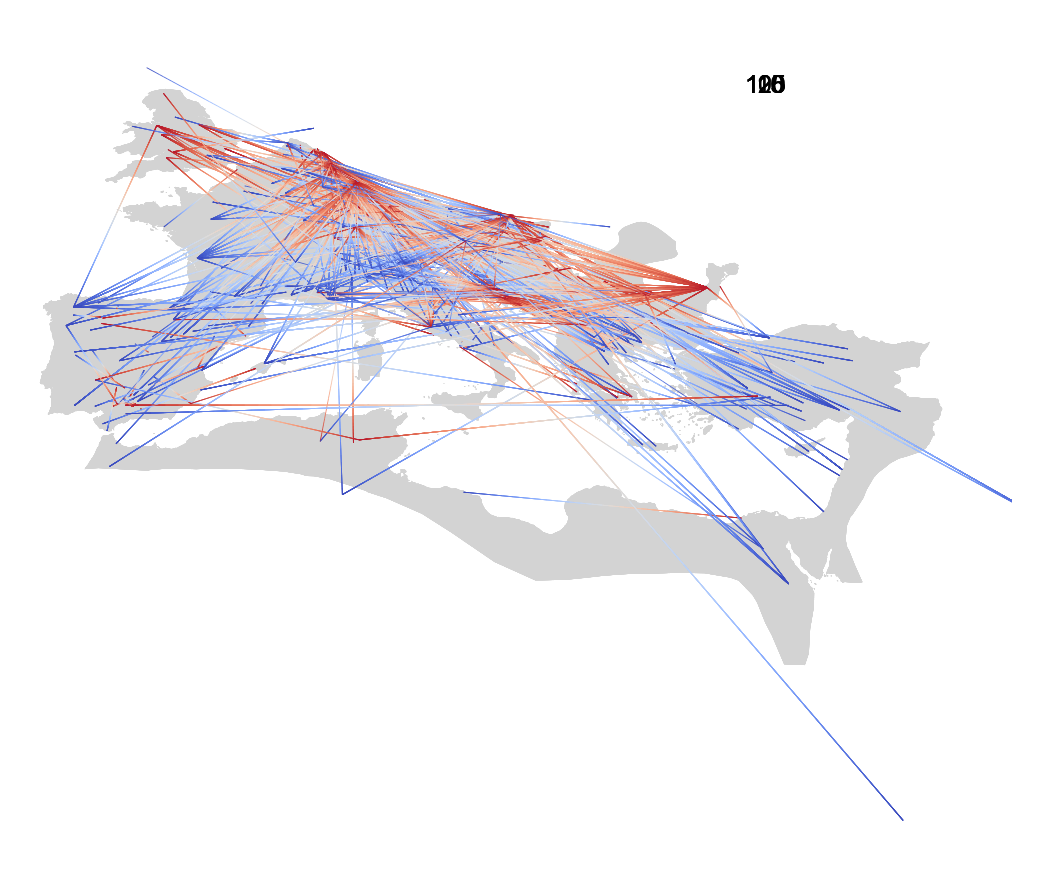

In [91]:
keep=50

fig = plt.figure(figsize=(5.2, 3), dpi=300, tight_layout=True)
ax = plt.axes()
ax.set_axis_off()
ax.set_xlim(-10,45)

camera = Camera(fig)
for year in range(100, 200, 5):
    gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
    list_subset = segmentlines_df[(segmentlines_df["year"]<=year) & (segmentlines_df["year"]>year-keep)]
    list_subset.plot(ax=ax, color=list_subset["color"], linewidth=0.2)
    ax.text(30,55, str(year), fontsize=6, color="black")
    camera.snap()
animation = camera.animate()
animation.save('../data/anim3_linesegments.gif')

# Points with changing color

In [58]:
points_n = 10
line = origo_geo.iloc[0]["origo_line"]
print(line)

LINESTRING (4.08476841415 50.7774935901, 6.868 51.0651)


In [59]:
print(Point(line.interpolate(1, normalized=True)))

POINT (6.868 51.0651)


In [60]:
points = [Point(line.interpolate((i / (points_n-1)), normalized=True)) for i in range(0,points_n)]
for point in points:
    print(point)

POINT (4.08476841415 50.7774935901)
POINT (4.394016368133333 50.80944985786667)
POINT (4.703264322116667 50.841406125633334)
POINT (5.0125122761 50.8733623934)
POINT (5.321760230083333 50.90531866116667)
POINT (5.631008184066667 50.937274928933334)
POINT (5.94025613805 50.9692311967)
POINT (6.249504092033334 51.00118746446667)
POINT (6.558752046016666 51.033143732233334)
POINT (6.868 51.0651)


In [61]:
markersizes = np.ones(10)
markersizes[0], markersizes[-1] = 3, 3

In [62]:
points_n = 50
cm = plt.get_cmap('coolwarm')
colors = list(cm([1 - (val / points_n) for val in range(points_n)]))
colors = list(cm([val / points_n for val in range(points_n)]))
markersizes = np.ones(points_n)
markersizes[0], markersizes[-1] = 3, 3
all_dates = []
all_points = []
all_colors = []
all_markersizes = []
step_len = 1
age = 50
for n in range(len(origo_geo)):
    line = origo_geo.iloc[n]["origo_line"]
    year = origo_geo.iloc[n]["random_date"]
    dates = range(year - age + step_len, year + step_len, step_len)
    points = [Point(line.interpolate((i / (points_n-1)), normalized=True)) for i in range(0,points_n)]
    all_dates.extend(dates)
    all_points.extend(points)
    all_colors.extend(colors)
    all_markersizes.extend(markersizes)
origo_linepoints_gdf = gpd.GeoDataFrame({"date": all_dates, "geometry": all_points, "color": all_colors, "markersize" : all_markersizes})
origo_linepoints_gdf

date                   geometry  \
0        143   POINT (4.08477 50.77749)   
1        144   POINT (4.14157 50.78336)   
2        145   POINT (4.19837 50.78923)   
3        146   POINT (4.25517 50.79510)   
4        147   POINT (4.31197 50.80097)   
...      ...                        ...   
113845   -51  POINT (11.89803 42.20880)   
113846   -50  POINT (12.04507 42.12952)   
113847   -49  POINT (12.19211 42.05025)   
113848   -48  POINT (12.33916 41.97097)   
113849   -47  POINT (12.48620 41.89170)   

                                                    color  markersize  
0              [0.2298057, 0.298717966, 0.753683153, 1.0]         3.0  
1       [0.2526625972549019, 0.3328367876470588, 0.783...         1.0  
2       [0.27582712294117645, 0.36671691552941177, 0.8...         1.0  
3       [0.2994412594117647, 0.40024818329411765, 0.83...         1.0  
4       [0.32371841525490197, 0.4331584405490196, 0.86...         1.0  
...                                                   ...         ...  
113845  [0.8393649370784314, 0.32185622094117644, 0.26...         1.0  
113846  [0.8155083866078432, 0.2777809871764706, 0.240...         1.0  
113847  [0.7905615319411765, 0.23139699905882352, 0.21...         1.0  
113848  [0.763520395627451, 0.17866744737254903, 0.193...         1.0  
113849  [0.7350766252941177, 0.10445963105882351, 0.17...         3.0  

[113850 rows x 4 columns]

In [63]:
len(origo_linepoints_gdf)

113850

In [64]:
origo_linepoints_gdf.to_parquet("../data/origo_linepoints_gdf.parquet")

In [66]:
year = 50
keep = 50
segmentlines_subset = segmentlines_df[(segmentlines_df["year"]>=year) & (segmentlines_df["year"]<year+keep)]
segmentlines_subset

year  not_before  not_after  \
650       84        71.0      130.0   
651       84        71.0      130.0   
652       84        71.0      130.0   
653       84        71.0      130.0   
654       84        71.0      130.0   
...      ...         ...        ...   
113695    95        71.0      100.0   
113696    95        71.0      100.0   
113697    95        71.0      100.0   
113698    95        71.0      100.0   
113699    95        71.0      100.0   

                                                    color  \
650            [0.2298057, 0.298717966, 0.753683153, 1.0]   
651     [0.2526625972549019, 0.3328367876470588, 0.783...   
652     [0.27582712294117645, 0.36671691552941177, 0.8...   
653     [0.2994412594117647, 0.40024818329411765, 0.83...   
654     [0.32371841525490197, 0.4331584405490196, 0.86...   
...                                                   ...   
113695  [0.8393649370784314, 0.32185622094117644, 0.26...   
113696  [0.8155083866078432, 0.2777809871764706, 0.240...   
113697  [0.7905615319411765, 0.23139699905882352, 0.21...   
113698  [0.763520395627451, 0.17866744737254903, 0.193...   
113699  [0.7350766252941177, 0.10445963105882351, 0.17...   

                                                 geometry   1BCE   1CE    2CE  \
650     LINESTRING (11.91345 45.79656, 11.92491 45.71846)  False  True   True   
651     LINESTRING (11.92491 45.71846, 11.93636 45.64036)  False  True   True   
652     LINESTRING (11.93636 45.64036, 11.94782 45.56227)  False  True   True   
653     LINESTRING (11.94782 45.56227, 11.95927 45.48417)  False  True   True   
654     LINESTRING (11.95927 45.48417, 11.97073 45.40607)  False  True   True   
...                                                   ...    ...   ...    ...   
113695  LINESTRING (16.38032 46.44968, 16.89162 46.55485)  False  True  False   
113696  LINESTRING (16.89162 46.55485, 17.40291 46.66001)  False  True  False   
113697  LINESTRING (17.40291 46.66001, 17.91421 46.76517)  False  True  False   
113698  LINESTRING (17.91421 46.76517, 18.42550 46.87034)  False  True  False   
113699  LINESTRING (18.42550 46.87034, 18.93680 46.97550)  False  True  False   

          3CE    4CE    5CE  
650     False  False  False  
651     False  False  False  
652     False  False  False  
653     False  False  False  
654     False  False  False  
...       ...    ...    ...  
113695  False  False  False  
113696  False  False  False  
113697  False  False  False  
113698  False  False  False  
113699  False  False  False  

[29500 rows x 11 columns]

MovieWriter ffmpeg unavailable; using Pillow instead.


CPU times: user 1h 16min 30s, sys: 36.7 s, total: 1h 17min 7s
Wall time: 1h 18min 57s


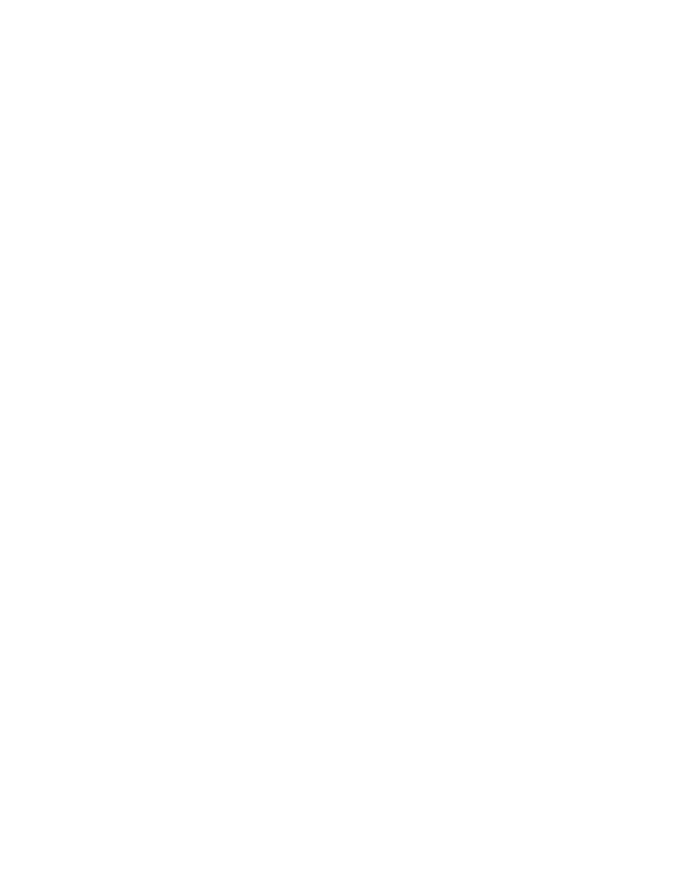

In [67]:
%%time
keep=50

fig = plt.figure(figsize=(5.2, 3), dpi=300, tight_layout=True)
ax = plt.axes()
ax.set_axis_off()
ax.set_xlim(-10,45)


camera = Camera(fig)
for year in range(-100, 500, 2):
    # lines
    gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
    segmentlines_subset = segmentlines_df[(segmentlines_df["year"]>=year) & (segmentlines_df["year"]<year+keep)]
    segmentlines_subset.plot(ax=ax, color=segmentlines_subset["color"], linewidth=0.2)
    # moving points
    linepoints_subset = origo_linepoints_gdf[origo_linepoints_gdf["date"]==year]
    linepoints_subset.plot(ax=ax, color=linepoints_subset["color"], markersize=linepoints_subset["markersize"])
    # staying dots
    sourcedest_subset = origo_geo[origo_geo["random_date"]<=year]
    sourcedest_subset.set_geometry("origo_point").plot(color="darkblue", markersize=1, alpha=0.3, ax=ax)
    sourcedest_subset.set_geometry("edh_point").plot(color="darkred", markersize=1, alpha=0.3, ax=ax)
    ax.text(30,55, str(year), fontsize=12, color="black")
    camera.snap()
animation = camera.animate()
animation.save('../data/anim4_linesegments+points_march23.gif')

# Network of provinces

In [24]:
provinces = gpd.read_file("../data/roman_province_boundaries.json")
#provinces = provinces.to_crs("EPSG:4326")
len(provinces)

61

In [25]:
pleiades_regions

name                                     uri  \
0                  Lusitania    http://pleiades.stoa.org/places/1101   
1                   Byzacena  http://pleiades.stoa.org/places/991345   
2                 Viennensis  http://pleiades.stoa.org/places/992074   
3         Lycia et Pamphylia  http://pleiades.stoa.org/places/981530   
4                      Savia  http://pleiades.stoa.org/places/991357   
..                       ...                                     ...   
142                 Aegyptus  http://pleiades.stoa.org/places/981503   
143                   Raetia  http://pleiades.stoa.org/places/981547   
144  Mauretania Caesariensis  http://pleiades.stoa.org/places/285482   
145                  Galliae  http://pleiades.stoa.org/places/992075   
146              Syria Coele  http://pleiades.stoa.org/places/991407   

                                              geometry  
0    POLYGON ((-7.31057 37.19663, -7.32457 37.19556...  
1    MULTIPOLYGON (((11.01815 34.62424, 11.00879 34...  
2    POLYGON ((4.62344 45.60642, 4.71224 45.60876, ...  
3    MULTIPOLYGON (((29.62331 36.07470, 29.61295 36...  
4    POLYGON ((18.10598 45.77203, 18.10654 45.71079...  
..                                                 ...  
142  MULTIPOLYGON (((33.96743 27.18697, 33.94941 27...  
143  POLYGON ((7.19022 45.77670, 7.22853 45.93539, ...  
144  POLYGON ((6.02188 36.86254, 6.11106 36.74744, ...  
145  MULTIPOLYGON (((-2.85190 47.33873, -2.85378 47...  
146  POLYGON ((40.23542 35.18410, 40.21662 35.13511...  

[147 rows x 3 columns]

In [26]:
origo_geo = origo_geo.set_geometry('edh_point')
origo_geo.crs = "EPSG:4326"

In [27]:
points_in_polygons = gpd.sjoin(origo_geo, provinces, how="left", op="within")

/Users/kasev/Projects/LIRE_ETL/lire_venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [28]:
points_in_polygons

Unnamed: 0          id     hd_nr                          origo  \
0          87598  HD075902/1  HD075902    cives(!) (= civis) Nervius+   
1          92334  HD081444/1  HD081444            natione(?)Pannonius   
2          62290  HD056833/3  HD056833        cives(= civis) Convena*   
3          19842  HD018231/1  HD018231  cives(= civis) Veliocassinius   
4          15178  HD010286/1  HD010286    natione+* [---] Aelia [---]   
...          ...         ...       ...                            ...   
2566       40288  HD037345/1  HD037345                 natione Zoela!   
2589       61629  HD056506/2  HD056506                        Ἐφέσιος   
2607       25320  HD025474/5  HD025474                       Μιλήσιος   
2637       13801  HD008584/6  HD008584                  natione verna   
2637       13801  HD008584/6  HD008584                  natione verna   

              origo_clean  pleiades_id pleiades_title_list  pleiades_Latitude  \
0         () (= ) Nervius     109199.0                 NaN          50.777494   
1             ()Pannonius     992076.0                 NaN          47.500000   
2            (= ) Convena     246357.0                 NaN          42.966682   
3     (= ) Veliocassinius     109412.0                 NaN          49.364001   
4       [---] Aelia [---]     197389.0                 NaN          45.560018   
...                   ...          ...                 ...                ...   
2566                Zoela     236724.0                 NaN          41.717349   
2589              Ἐφέσιος     599612.0                 NaN          37.940762   
2607             Μιλήσιος     599799.0                 NaN          37.522905   
2637                  NaN     167964.0                 NaN          45.776152   
2637                  NaN     167964.0                 NaN          45.776152   

      pleiades_Longitude       pleiades_title  ... Unnamed: 26  \
0               4.084768               Nervii  ...         NaN   
1              12.500000            Pannoniae  ...         NaN   
2               0.269919             Convenae  ...         NaN   
3               0.831097          Veliocasses  ...         NaN   
4              18.675749                Mursa  ...         NaN   
...                  ...                  ...  ...         ...   
2566           -6.628006               Zoelae  ...         NaN   
2589           27.340307  Ephesus/Arsinoe(ia)  ...         NaN   
2607           27.278317              Miletus  ...         NaN   
2637            5.281057               Vernas  ...         NaN   
2637            5.281057               Vernas  ...         NaN   

                               origo_point                   geometry  \
0      POINT (4.08476841415 50.7774935901)   POINT (4.08477 50.77749)   
1                        POINT (12.5 47.5)  POINT (12.50000 47.50000)   
2     POINT (0.269918733812 42.9666817568)   POINT (0.26992 42.96668)   
3     POINT (0.831097476911 49.3640014746)   POINT (0.83110 49.36400)   
4              POINT (18.675749 45.560018)  POINT (18.67575 45.56002)   
...                                    ...                        ...   
2566  POINT (-6.62800608445 41.7173488189)  POINT (-6.62801 41.71735)   
2589          POINT (27.340307 37.9407625)  POINT (27.34031 37.94076)   
2607   POINT (27.2783168333 37.5229047333)  POINT (27.27832 37.52290)   
2637            POINT (5.281057 45.776152)   POINT (5.28106 45.77615)   
2637            POINT (5.281057 45.776152)   POINT (5.28106 45.77615)   

                      edh_point random_date  not_before not_after  \
0      POINT (6.86800 51.06510)       192.0       101.0     300.0   
1     POINT (-0.20880 51.46410)       220.0       101.0     300.0   
2      POINT (2.09200 41.38390)       107.0       107.0     107.0   
3      POINT (3.87770 51.61560)       211.0       151.0     250.0   
4     POINT (12.48620 41.89170)       171.0       141.0     200.0   
...                         ...         ...         ...       ...   
256

In [53]:
provinces[1:10]

province  \
1                    Alpes Poeninae   
2                      Alpes Graiae   
3                 Umbria (Regio VI)   
4                 Picenum (Regio V)   
5                Samnium (Regio IV)   
6      Latium et Campania (Regio I)   
7               Etruria (Regio VII)   
8            Transpadana (Regio XI)   
9                Liguria (Regio IX)   
10             Aemilia (Regio VIII)   
11                    Alpes Cottiae   
12                  Alpes Maritimae   
13     Venetia et Histria (Regio X)   
14  Bruttium et Lucania (Regio III)   
15                          Sicilia   
16                         Sardinia   
17                          Corsica   
18    Apulia et Calabria (Regio II)   
19                             Asia   
20                        Britannia   
21                            Creta   
22                           Cyprus   
23                Germania Superior   
24                          Belgica   
25                      Narbonensis   
26                        Aquitania   
27                      Lugdunensis   
28                Germania Inferior   
29                        Lusitania   
30                          Baetica   
31                          Assyria   
32                          Armenia   
33               Lycia et Pamphylia   
34               Bithynia et Pontus   
35                      Mesopotamia   
36                          Galatia   
37                       Cappadocia   
38                          Cilicia   
39                        Macedonia   
40                           Epirus   
41                Hispania Citerior   
42                          Noricum   
43                Pannonia Inferior   
44                Pannonia Superior   
45                           Cyrene   
46                         Aegyptus   
47          Mauretania Caesariensis   
48                          Numidia   
49             Africa Proconsularis   
50             Mauretania Tingitana   
51                           Raetia   
52                          Thracia   
53                           Arabia   
54                            Syria   
55                           Iudaea   
56                  Moesia Inferior   
57                  Moesia Superior   
58                            Dacia   
59                         Dalmatia   
60                             Roma   

                                             geometry  
1   POLYGON ((6.88843 45.93874, 7.22626 45.93205, ...  
2   POLYGON ((7.22626 45.93181, 7.17407 45.60443, ...  
3   POLYGON ((13.29895 43.67383, 13.03253 43.84641...  
4   POLYGON ((14.19640 42.48754, 14.28738 42.42700...  
5   POLYGON ((15.04337 41.97506, 14.95514 41.96715...  
6   POLYGON ((12.46262 41.61544, 12.35687 41.69753...  
7   POLYGON ((12.02454 41.98399, 12.05269 41.94826...  
8   POLYGON ((10.05043 45.13289, 9.86023 45.05024,...  
9   POLYGON ((7.53113 45.00754, 7.42126 44.85197, ...  
10  POLYGON ((8.85601 44.92543, 9.05308 45.02744, ...  
11  POLYGON ((6.59729 45.46013, 6.56708 45.33863, ...  
12  POLYGON ((6.55334 44.35037, 6.79916 44.36362, ...  
13  POLYGON ((9.48994 46.19080, 9.60689 46.18744, ...  
14  POLYGON ((15.95316 39.46733, 15.94762 39.47207...  
15  MULTIPOLYGON (((14.50173 35.85743, 14.48112 35...  
16  MULTIPOLYGON (((8.41969 38.93054, 8.39556 38.9...  
17  MULTIPOLYGON (((8.57750 41.83391, 8.57287 41.8...  
18  MULTIPOLYGON (((15.40990 41.89812, 15.48851 41...  
19  MULTIPOLYGON (((25.88379 39.28117, 25.83435 39...  
20  MULTIPOLYGON (((-4.86557 55.76576, -4.90402 55...  
21  POLYGON ((23.58971 35.62605, 23.58559 35.61544...  
22  POLYGON ((34.58496 35.70415, 34.46960 35.66176...  
23  POLYGON ((7.28531 50.54104, 7.38266 50.48384, ...  
24  POLYGON ((0.85217 49.87818, 0.80477 49.90538, ...  
25  MULTIPOLYGON (((6.35863 42.96965, 6.31770 42.9...  
26  MULTIPOLYGON (((-1.21477 45.87237, -1.27402 45...  
27  MULTIPOLYGON (((-2.82829 47.34807, -2.85378 47...  
28  MULTIPOLYGON (((4.38005 51.47463, 4.35292 51.4...  
29  POLYGON ((-7.31057 

In [50]:
origo_geo.within(provinces.geometry[0]).sum()

f the input geometry is invalid.


TopologicalError: The operation 'GEOSWithin_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.multipolygon.MultiPolygon object at 0x2aa76bc70>

In [52]:
provinces["province"]

province                                           geometry
0              Achaia  MULTIPOLYGON (((21.35399 38.40249, 21.31554 38...
1      Alpes Poeninae  POLYGON ((6.88843 45.93874, 7.22626 45.93205, ...
2        Alpes Graiae  POLYGON ((7.22626 45.93181, 7.17407 45.60443, ...
3   Umbria (Regio VI)  POLYGON ((13.29895 43.67383, 13.03253 43.84641...
4   Picenum (Regio V)  POLYGON ((14.19640 42.48754, 14.28738 42.42700...
..                ...                                                ...
56    Moesia Inferior  POLYGON ((27.96021 44.48867, 27.88330 44.89090...
57    Moesia Superior  POLYGON ((20.42444 43.12918, 20.26708 43.25640...
58              Dacia  POLYGON ((23.62370 43.78894, 23.55881 43.80356...
59           Dalmatia  MULTIPOLYGON (((16.42689 42.37942, 16.41098 42...
60               Roma  POLYGON ((12.47017 41.87876, 12.47309 41.87090...

[61 rows x 2 columns]

In [191]:
for province_geo, province_name in zip(provinces.geometry, provinces["province"]):
    try:
        origo_geo.within(province_geo)


    origo_geo["edh_point"].to_crs("EPSG:4326")

AttributeError: 'Series' object has no attribute 'to_crs'

In [186]:
data = origo_geo["origo_point"].within(provinces)
data

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_36467/610613490.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  data = origo_geo["origo_point"].within(provinces)


0       False
1       False
2       False
3       False
4       False
        ...  
2564    False
2566    False
2589    False
2607    False
2637    False
Length: 2316, dtype: bool

<AxesSubplot: >

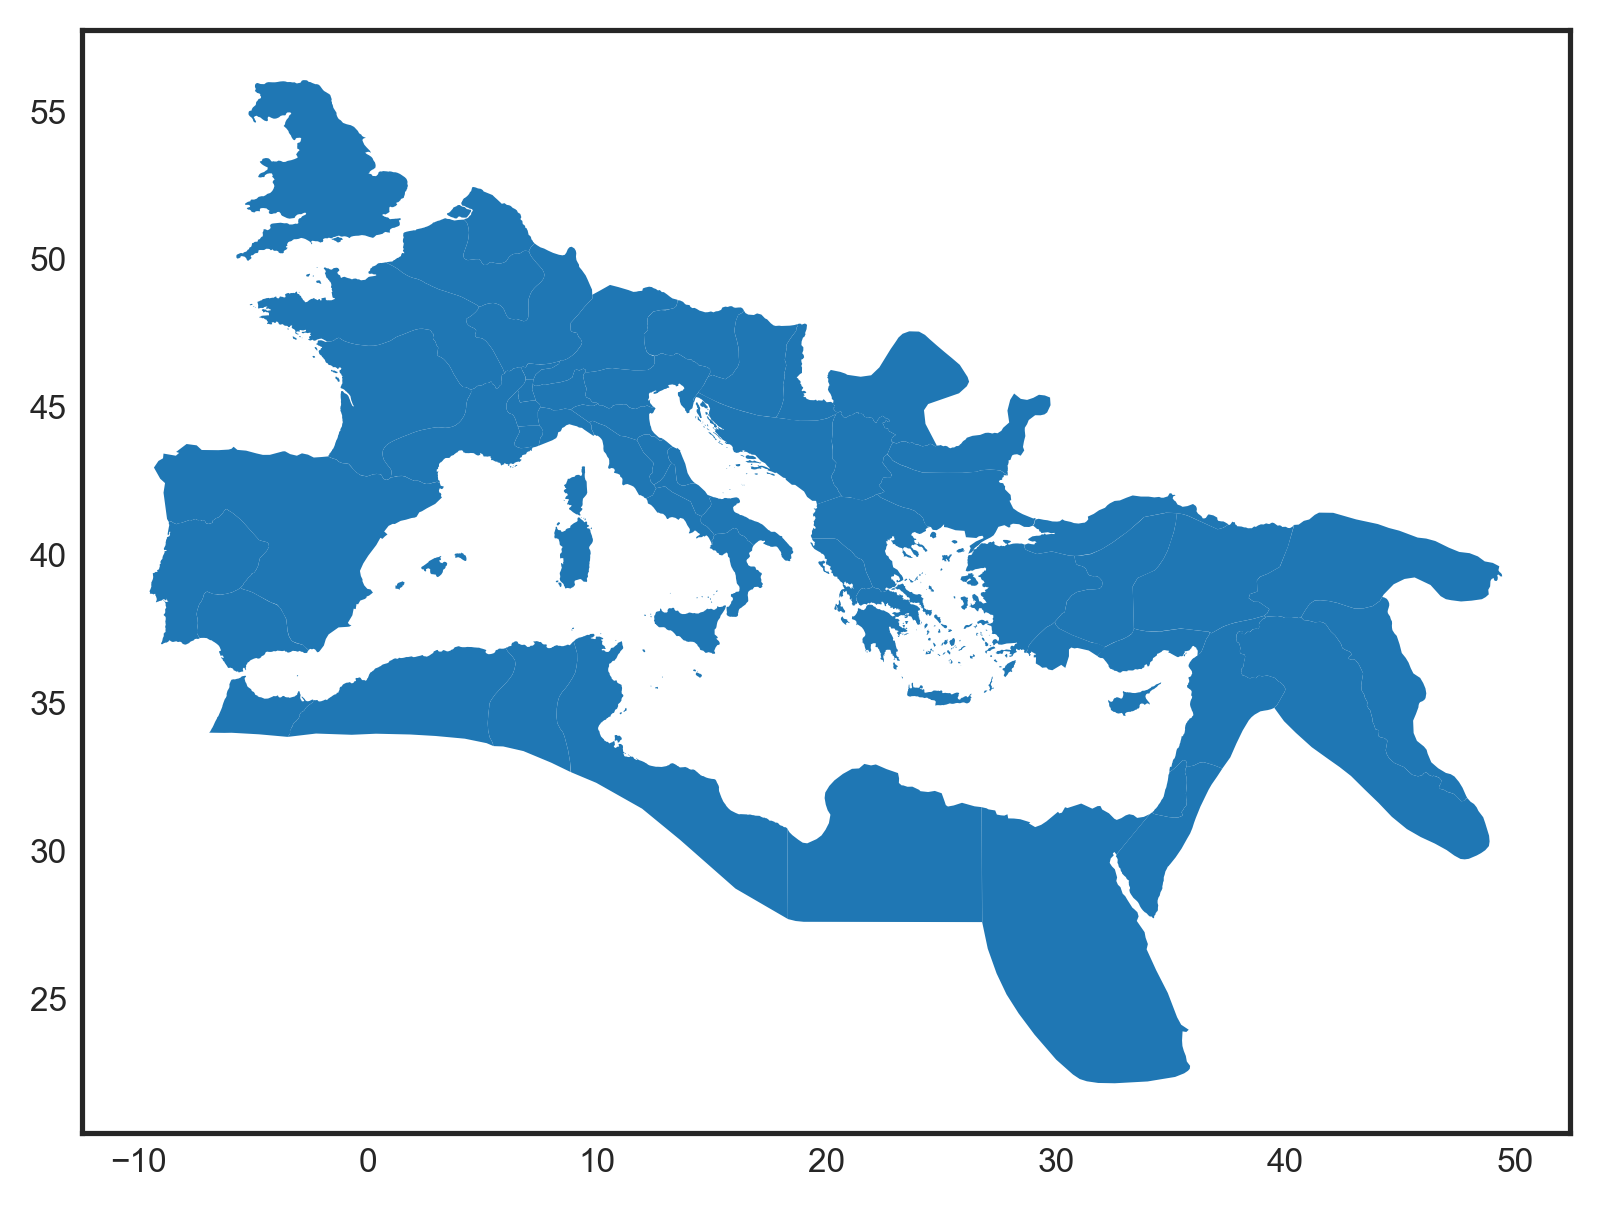

In [179]:
provinces.plot(linewidth=4)

In [168]:
pleiades_regions

name                                     uri  \
0                  Lusitania    http://pleiades.stoa.org/places/1101   
1                   Byzacena  http://pleiades.stoa.org/places/991345   
2                 Viennensis  http://pleiades.stoa.org/places/992074   
3         Lycia et Pamphylia  http://pleiades.stoa.org/places/981530   
4                      Savia  http://pleiades.stoa.org/places/991357   
..                       ...                                     ...   
142                 Aegyptus  http://pleiades.stoa.org/places/981503   
143                   Raetia  http://pleiades.stoa.org/places/981547   
144  Mauretania Caesariensis  http://pleiades.stoa.org/places/285482   
145                  Galliae  http://pleiades.stoa.org/places/992075   
146              Syria Coele  http://pleiades.stoa.org/places/991407   

                                              geometry  
0    POLYGON ((-7.31057 37.19663, -7.32457 37.19556...  
1    MULTIPOLYGON (((11.01815 34.62424, 11.00879 34...  
2    POLYGON ((4.62344 45.60642, 4.71224 45.60876, ...  
3    MULTIPOLYGON (((29.62331 36.07470, 29.61295 36...  
4    POLYGON ((18.10598 45.77203, 18.10654 45.71079...  
..                                                 ...  
142  MULTIPOLYGON (((33.96743 27.18697, 33.94941 27...  
143  POLYGON ((7.19022 45.77670, 7.22853 45.93539, ...  
144  POLYGON ((6.02188 36.86254, 6.11106 36.74744, ...  
145  MULTIPOLYGON (((-2.85190 47.33873, -2.85378 47...  
146  POLYGON ((40.23542 35.18410, 40.21662 35.13511...  

[147 rows x 3 columns]

In [ ]:
# next option might be: https://pydeck.gl
#see example here: https://pydeck.gl/gallery/arc_layer.html
# or https://pydeck.gl/gallery/great_circle_layer.html


# On Orbis network

In [ ]:
G = nx.read_graphml("../data/orbis_network_enriched.graphml")

In [ ]:
G.edges(data=True)

# Adela's data

In [ ]:
orig_dest155 = gpd.read_file("../data/orig_dest155.geojson", driver="GeoJSON")

In [ ]:
orig_dest155.plot()

In [ ]:
# - start with simple space-abstracted animation of dots moving from origo to destintion
# - in a next step, we will move it to Orbis


In [30]:
origo_points_list = []
step_len = 5
age = 50
for n in range(len(origo_geo)):
    line = origo_geo.iloc[n]["origo_line"]
    year = origo_geo.iloc[n]["random_date"]
    color = random.choice(list(mcolors.TABLEAU_COLORS.keys()))
    dates = range(year-age+step_len,year+step_len, step_len)
    for i,y in enumerate(dates):
        data = {
            "date": y,
            "geometry" : Point(line.interpolate((i/len(dates)), normalized=True)),
            "color" : color
        }
        origo_points_list.append(data)

In [31]:
origo_geo

LIST-ID        EDCS-ID    EDH-ID  \
445538   445539  EDCS-24900101  HD064259   
445571   445572  EDCS-11700037  HD019463   
445574   445575  EDCS-11700044  HD013721   
446675   446676  EDCS-20700285  HD023339   
446733   446734  EDCS-09300905  HD006780   
...         ...            ...       ...   
524327   524328           None  HD078033   
524329   524330           None  HD078035   
524342   524343           None  HD078058   
524485   524486           None  HD078279   
525600   525601           None  HD080290   

                                trismegistos_uri pleiades_id  \
445538  https://www.trismegistos.org/text/178228               
445571  https://www.trismegistos.org/text/177113               
445574  https://www.trismegistos.org/text/177091               
446675  https://www.trismegistos.org/text/244141      109008   
446733  https://www.trismegistos.org/text/264182      423025   
...                                          ...         ...   
524327                                      None      109169   
524329                                      None      109169   
524342                                      None      109169   
524485                                      None      109169   
525600                                      None      177661   

                                            transcription  \
445538  N(umerius) &lt;G=C&gt;ranonius N(umeri) f(iliu...   
445571               [---] Viruno / [--- v]ixit / [------   
445574  C(aio) Mucio C(ai) f(ilio) Cla/udio Gemenel(l)...   
446675  V(ivus) f(ecit) // L(ucius) Ursius / Sosander ...   
446733  Sex(tus) Gracch[ius] / T(iti) f(ilius) Pol(lia...   
...                                                   ...   
524327  L(ucius) Antest[i]us / M(arci) f(ilius) Ani(en...   
524329  ------](?) / [---]I(?)M(?)[---] / [---] Tolo[s...   
524342  [------] / Atinius / Sept&lt;i&gt;mi / f(ilius...   
524485  [---]us M(arci) / [f(ilius) Le]m(onia) Bon(oni...   
525600  [Di]s Manib(us) / G(aius) Ennius G(ai) f(ilius...   

                                              inscription  \
445538  N(umerius) Granonius N(umeri) f(ilius) <G=C>al...   
445571                           ] Viruno / [3 v]ixit / [   
445574  G(aio!) Mucio G(ai!) f(ilio) Cla/udio Gemenelo...   
446675  V(ivus) f(ecit) / L(ucius) Ursius / Sosander /...   
446733  Sex(tus) Gracchi[us] / T(iti) f(ilius) Pol(lia...   
...                                                   ...   
524327                                               None   
524329                                               None   
524342                                               None   
524485                                               None   
525600                                               None   

                                  clean_text_conservative  \
445538  N lt C gt ranonius N f Cal domo Luceria IIII v...   
445571                                        Viruno ixit   
445574  C Mucio C f Claudio Gemenelo mathe tr ex class...   
446675  V f L Ursius Sosander vestiar Bonon sibi et Ru...   
446733  Sex Gracch T f Pol Fronto Faventia miles coh I...   
...                                                   ...   
524327  L Antestus M f Ani Tertius Cremon mil leg an L...   
524329                                    IM Tolo eg I st   
524342  Atinius Sept lt i gt mi f Romilia Ateste mil l...   
524485                                         us M m Bon   
525600  s Manib G Ennius G f Vetur Titus Placent mil l...   

                         clean_text_interpretive_sentence  \
445538  Numerius lt;G gt;ranonius Numeri filius Cal do...   
445571                                       Viruno vixit   
445574  Caio Mucio Cai filio Claudio Gemenello mathema...   
446675  Vivus fecit Lucius Ursius Sosander vestiarius ...   
446733  Sextus Gracchius Titi filius Pollia Fronto Fav...   
...                                                   ...   
524327  Lucius Antestius Marci filius Aniensis Tertius...   
524329               IM

In [32]:
gpd.GeoDataFrame(origo_points_list)

date                   geometry     color
0      -62  POINT (15.33547 41.50865)  tab:cyan
1      -57  POINT (16.17473 41.15620)  tab:cyan
2      -52  POINT (17.01398 40.80375)  tab:cyan
3      -47  POINT (17.85323 40.45130)  tab:cyan
4      -42  POINT (18.69248 40.09885)  tab:cyan
...    ...                        ...       ...
5235    93   POINT (8.95808 46.26624)  tab:pink
5236    98   POINT (8.81017 46.50897)  tab:pink
5237   103   POINT (8.66225 46.75171)  tab:pink
5238   108   POINT (8.51433 46.99444)  tab:pink
5239   113   POINT (8.36642 47.23717)  tab:pink

[5240 rows x 3 columns]

In [33]:
origo_points_list

[{'date': -62,
  'geometry': <shapely.geometry.point.Point at 0x2b7471d30>,
  'color': 'tab:cyan'},
 {'date': -57,
  'geometry': <shapely.geometry.point.Point at 0x2b771a820>,
  'color': 'tab:cyan'},
 {'date': -52,
  'geometry': <shapely.geometry.point.Point at 0x2b771a1c0>,
  'color': 'tab:cyan'},
 {'date': -47,
  'geometry': <shapely.geometry.point.Point at 0x2b771a5b0>,
  'color': 'tab:cyan'},
 {'date': -42,
  'geometry': <shapely.geometry.point.Point at 0x2b771a5e0>,
  'color': 'tab:cyan'},
 {'date': -37,
  'geometry': <shapely.geometry.point.Point at 0x2b793c850>,
  'color': 'tab:cyan'},
 {'date': -32,
  'geometry': <shapely.geometry.point.Point at 0x2b771aaf0>,
  'color': 'tab:cyan'},
 {'date': -27,
  'geometry': <shapely.geometry.point.Point at 0x2b771ae20>,
  'color': 'tab:cyan'},
 {'date': -22,
  'geometry': <shapely.geometry.point.Point at 0x2b771aca0>,
  'color': 'tab:cyan'},
 {'date': -17,
  'geometry': <shapely.geometry.point.Point at 0x2b771a910>,
  'color': 'tab:cyan'},


In [34]:
n = 0
line = origo_geo.iloc[n]["origo_line"]
line = origo_geo.iloc[n]["origo_line"]
year = origo_geo.iloc[n]["random_date"]
color = random.choice(list(mcolors.TABLEAU_COLORS.keys()))
dates = range(year-age+step_len,year+step_len, step_len)
print(Point(line.interpolate(0.12, normalized=True)))

POINT (16.342575676 41.085707716)


In [35]:
[Point(line.interpolate((i/(len(dates)-2)), normalized=True)) for i in range(len(dates) - 2)]

In [53]:
[Point(line.split((i/(len(dates)-2)), normalized=True)) for i in range(len(dates) - 2)]


AttributeError: 'LineString' object has no attribute 'split'

In [36]:
colors = [random.choice(list(mcolors.TABLEAU_COLORS.keys()))] * len(dates)
colors

['tab:purple',
 'tab:purple',
 'tab:purple',
 'tab:purple',
 'tab:purple',
 'tab:purple',
 'tab:purple',
 'tab:purple',
 'tab:purple',
 'tab:purple']

In [37]:
all_dates = []
all_points = []
all_colors = []
step_len = 5
age = 50
for n in range(len(origo_geo)):
    line = origo_geo.iloc[n]["origo_line"]
    year = origo_geo.iloc[n]["random_date"]
    colors = [random.choice(list(mcolors.TABLEAU_COLORS.keys()))] * len(dates)
    dates = range(year-age+step_len,year+step_len, step_len)
    points = [Point(line.interpolate((i/(len(dates)-3)), normalized=True)) for i in range(len(dates) - 2)]
    points = [origo_geo.iloc[n]["origo_point"]] + points +  [origo_geo.iloc[n]["edh_point"]]
    all_dates.extend(dates)
    all_points.extend(points)
    all_colors.extend(colors)

In [38]:
origo_linepoints_gdf = gpd.GeoDataFrame({"date" : all_dates, "geometry" : all_points, "color" : all_colors})
origo_linepoints_gdf

date                   geometry       color
0      -62  POINT (15.33547 41.50865)    tab:pink
1      -57  POINT (15.33547 41.50865)    tab:pink
2      -52  POINT (16.53440 41.00515)    tab:pink
3      -47  POINT (17.73333 40.50165)    tab:pink
4      -42  POINT (18.93226 39.99815)    tab:pink
...    ...                        ...         ...
5235    93   POINT (8.85243 46.43962)  tab:purple
5236    98   POINT (8.64112 46.78638)  tab:purple
5237   103   POINT (8.42981 47.13314)  tab:purple
5238   108   POINT (8.21850 47.47990)  tab:purple
5239   113   POINT (8.21850 47.47990)  tab:purple

[5240 rows x 3 columns]

MovieWriter ffmpeg unavailable; using Pillow instead.


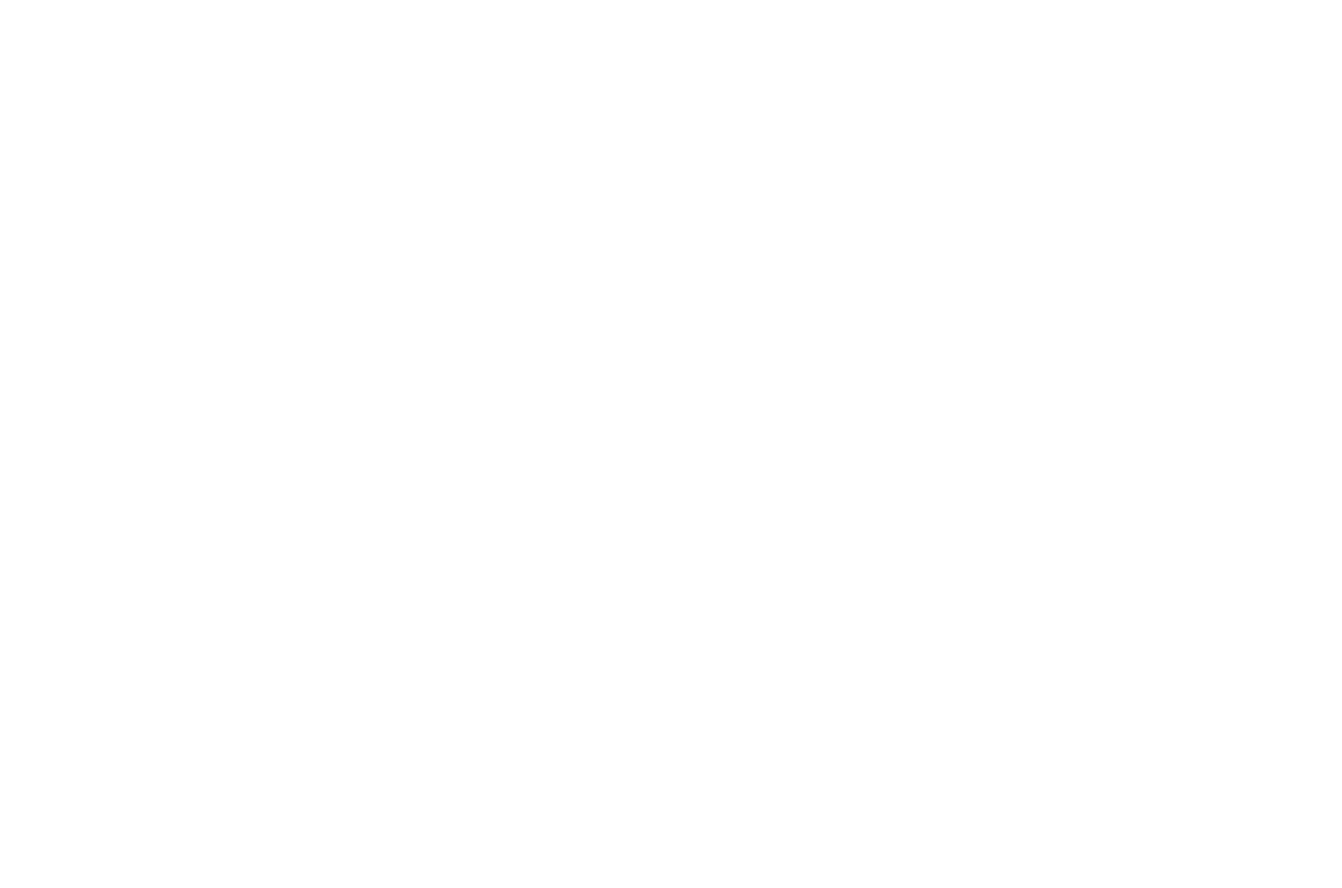

In [96]:
fig = plt.figure(figsize=(5.2, 3), dpi=300, tight_layout=True)
ax = plt.axes()
ax.set_axis_off()
ax.set_xlim(-10,45)
step = 5

camera = Camera(fig)
for year in range(-50, 450, step):
    gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
    list_subset = origo_linepoints_gdf[origo_linepoints_gdf["date"].between(year-4, year)]
    list_subset.plot(ax=ax, markersize=1, color=list_subset["color"])
    ax.text(30,55, str(year), fontsize=6, color="black")
    camera.snap()
animation = camera.animate()
animation.save('../data/anim1_linepoints.gif')

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

In [71]:
x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))

array([ 9.99955409e-01,  9.99598704e-01,  9.98885422e-01,  9.97815817e-01,
        9.96390270e-01,  9.94609290e-01,  9.92473513e-01,  9.89983699e-01,
        9.87140738e-01,  9.83945644e-01,  9.80399556e-01,  9.76503739e-01,
        9.72259583e-01,  9.67668602e-01,  9.62732434e-01,  9.57452839e-01,
        9.51831701e-01,  9.45871024e-01,  9.39572937e-01,  9.32939684e-01,
        9.25973632e-01,  9.18677266e-01,  9.11053189e-01,  9.03104121e-01,
        8.94832897e-01,  8.86242467e-01,  8.77335896e-01,  8.68116362e-01,
        8.58587152e-01,  8.48751667e-01,  8.38613415e-01,  8.28176011e-01,
        8.17443181e-01,  8.06418751e-01,  7.95106655e-01,  7.83510928e-01,
        7.71635707e-01,  7.59485227e-01,  7.47063824e-01,  7.34375927e-01,
        7.21426063e-01,  7.08218851e-01,  6.94759004e-01,  6.81051321e-01,
        6.67100693e-01,  6.52912097e-01,  6.38490593e-01,  6.23841327e-01,
        6.08969524e-01,  5.93880488e-01,  5.78579603e-01,  5.63072327e-01,
        5.47364192e-01,  

In [ ]:

# Create a set of line segments so that we can color them individually
# This creates the points as an N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])

# Use a boundary norm instead
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[1].add_collection(lc)
fig.colorbar(line, ax=axs[1])

axs[0].set_xlim(x.min(), x.max())
axs[0].set_ylim(-1.1, 1.1)
plt.show()

In [ ]:
# for lines: https://stackoverflow.com/questions/36074455/python-matplotlib-with-a-line-color-gradient-and-colorbar
colormap = "coolwarm"

In [101]:
year = 150
origo_linepoints_gdf[origo_linepoints_gdf["date"].between(year-4, year)]

date                   geometry       color
44     148  POINT (12.14180 43.26001)    tab:pink
80     147   POINT (5.76568 36.82098)     tab:red
248    149  POINT (-2.89520 53.18550)    tab:pink
497    149  POINT (22.10765 46.00505)   tab:green
521    146  POINT (13.47026 43.10549)  tab:orange
...    ...                        ...         ...
4975   148  POINT (10.40316 42.70489)   tab:brown
4983   146  POINT (11.28006 44.22666)   tab:green
4994   146  POINT (11.19302 43.97631)    tab:pink
5011   149  POINT (13.51607 43.61899)    tab:pink
5035   150  POINT (11.44018 43.30727)  tab:orange

[98 rows x 3 columns]

# On Orbis network

In [10]:
G = nx.read_graphml("../data/orbis_network_enriched.graphml")

In [11]:
G.edges(data=True)

EdgeDataView([('50001', '50056', {'km': 54.539, 'expense_inverse': 0.5238344683080146, 'expense': 1.909, 'days': 1.818, 'route_type': 'road/road', 'gravity': 274.4025501875404, 'gravity_inverse': 0.0036442810000000005}), ('50001', '50100', {'km': 50.135, 'expense_inverse': 0.5698005698005698, 'expense': 1.755, 'days': 1.671, 'route_type': 'road/road', 'gravity': 324.67268934505404, 'gravity_inverse': 0.0030800249999999997}), ('50001', '50293', {'km': 65.681, 'expense_inverse': 0.43497172683775553, 'expense': 2.299, 'days': 2.189, 'route_type': 'road/road', 'gravity': 189.20040314821904, 'gravity_inverse': 0.0052854009999999995}), ('50001', '50473', {'km': 225.368, 'expense_inverse': 0.12677484787018256, 'expense': 7.888, 'days': 7.512, 'route_type': 'road/road', 'gravity': 16.07186205250793, 'gravity_inverse': 0.062220543999999996}), ('50056', '50314', {'km': 126.177, 'expense_inverse': 0.22644927536231882, 'expense': 4.416, 'days': 4.206, 'route_type': 'road/road', 'gravity': 543.9705

# Adela's data

In [6]:
orig_dest155 = gpd.read_file("../data/orig_dest155.geojson", driver="GeoJSON")

<AxesSubplot: >

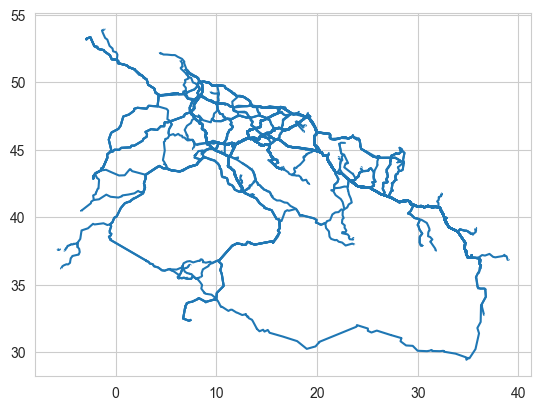

In [7]:
orig_dest155.plot()

In [8]:
# - start with simple space-abstracted animation of dots moving from origo to destintion
# - in a next step, we will move it to Orbis
